# Image Recognition Analysis

### The Problem

Can we utilize machine learning to correctly identify images by training on pre-labeled images that were previously labeled by a different machine?  In other words, can machines teach machines to recognize images?  

### The Client

This topic would be of interest to robotics firms to assist in robotic navigation, to law enforcement agencies (to assist in the facial recognition of suspects) or to intelligence agencies (to aid in recognizing targets of interest in aerial reconnaissance photographs).  If successful, it may obviate or reduce the need to have large numbers of human beings pre-label images in every case.  Instead, a client could save money if image recognition training could always be done based on pre-labeled images done by machines that were in turn trained by other machines that were ultimately trained on only one or two human pre-labeling sessions long ago.  
	
### The Data

The dataset was taken from the Open Images dataset available [here](https://storage.googleapis.com/openimages/web/download.html).   The full set consists of 9,178,275 images with 19,995 classes.  There is also a smaller subset of the data consisting of 1,743,042 training images with 601 classes. The data for the image labels and image id’s are available as csv files.  

### The Approach

1.	Data wrangling and cleaning—First I determined which of the machine-learned labels and id’s in the training set correspond to the training labels and id’s for the image subset given and narrowed the training set down to only those labels and id’s.  (The machine learned training set was taken from all 9,178,275 images, while the images used here will be from a more manageable subset.)  I also made certain that I narrowed the set further to only those labels that were identified with certainty by a human observer as confirmation in addition to the machine's estimate/assignment of the label so as not to introduce too much uncertainty into the present model.    
2.	Exploratory Data Analysis—Here, I briefly analyzed relationships among the variables in the dataset using both statistical functions and graphical analyses. This primarily involved an analysis of the frequencies and types of labels present in the dataset, as these were the variables most amenable to analysis.
3.	Machine Learning—I then built a deep learning model using a convolutional neural network to identify the images.  The object was to determine whether and to what extent one deep learning model may accurately recognize images that have been labeled by a different machine and to see how confident both machines were in the identification.
4.	Final Report—Below, I have provided a detailed report describing the procedure I used and the findings I obtained therefrom, including appropriate data visualizations.  Accompanying this report is a slide deck providing a high level summary. All of the foregoing has been submitted and published on GitHub.

Note:  Excerpts from this report are also repeated below in the code section in the relevant areas to which they pertain. What follows immediately below is the report in its entirety.  



## Data Cleaning

I obtained the data from the Open Images Dataset V4 located [here](https://storage.googleapis.com/openimages/web/download.html).  This data consists of images and labels intended for multilabel classification.  The full set consists of 9,178,275 images with 19,995 classes.  There is also a smaller subset of the data consisting of 1,743,042 training images with 601 classes. (As demonstrated below, the number of classes given by the source website as 600 is not correct.  The csv file from which the labels and class names  were obtained is unaltered and is directly from the source site. There are no null values or duplicate values present, as shown by executing the info and duplicated methods on the dataframe read in from the source csv file.) 

In an effort to simplify the problem at hand to one of single label classification and due to inherent hardware limitations (i.e., lack of a gpu), I chose the smaller dataset with 601 classes.  However, since I also wanted to look at the initial machine confidence level in choosing these labels and compare them to what was ultimately predicted here, I also needed to use the larger dataset containing this information that was not included in the smaller dataset.  Accordingly, I merged the larger and smaller datasets on ImageID and LabelName in order to get those images and labels common to both (the smaller set being a subset of the larger set), and called it **label_train_merge**. 

I then created a dictionary for translating the label names to the Class Names given in the class_names_short dataframe.  This dictionary was then used to create a new variable 'ClassName' for the label_train_merge dataframe which gives English names for each label. 

Since there were now two Confidence columns and two Source columns as a result of the merge, one each for machine and human confidence and sources respectively, I renamed the variables accordingly as 'Confidence_Machine' and 'Confidence_Human' and Source_Machine and Source_Human.  

The Confidence_Machine variable signifies the confidence on a scale from 0 to 1 that the machine had in giving the label to the image (essentially a probability that the label predicted applied to the image).  The Confidence_Human variable is more definite and was either 0 or 1 depending on whether the human observer definitely thought the particular label applied to the image or not.  

For example, in the dataframe below, the human identified the first image listed as being definitely a building, but not a house or a tower. The machine was less certain.  While it agreed that it was a building with an 80% probability, it also predicted it to be a house with a 70% probability and a tower with a 60% probability. 

In an effort to simplify matters for machine learning purposes here so that we can have full confidence in all the labels given as our "ground truth", I limited the dataframe to only those labels with a Confidence_Human value of 1.  I then dropped any duplicate ImageID values so that the set would consist only of 1 LabelName/ClassName per ImageID for single label classification.  This resulted in a reduced dataset with 959,927 images and 512 unique ClassNames.  The dataframe was then pickled for ease of future access and was ready for further analysis.

Note:  While the Open Images source website provided additional datasets for validation and test purposes, this larger training dataset was used here for all purposes, such that the validation and test sets were carved out from it. When similar merging and reducing processes were applied to the given validation and test sets, it resulted in a different number of unique ClassNames, and this posed a problem when applying them to the machine learning algorithms used here which require the same number of labels in the training, validation and test sets for comparison.  Accordingly, since the training set is so large, even after the merging and reductions used here, I was able to later use the training data as the overall source data and carve out and isolate adequately sized validation and test sets from the rest of the data to ensure the same number of labels for all sets.

## Exploratory Data Analysis

I began by taking a count of all of the different class names present in the dataset. While there are 512 unique class names, some of these occur much more frequently than others.  As can be observed below, many of the class names are synonyms for one another, or else one term is a more general description of another ("Building" vs. "Skyscraper", "Vehicle" vs. "Car" or "Animal" vs. "Cat", for example). In other instances, one class name may refer to the part of a whole represented by another class name ("Human face" vs. "Person" or "Man", for example).  The more general terms naturally tend to have higher counts than the more specific terms.

I then chose 10 random ImageID's and corresponding ClassNames and drew the actual images by their ID's from the appropriate directory. Each of the images was plotted along with the image's shape, label, the number of times the label appears in the dataset and the probability that the machine involved in pre-labeling the image would assign that particular label for the image in question. 

As can be seen below, the images are of varying shapes. They will therefore have to be transformed into a uniform shape later in order to be analyzed properly in the neural network to be built.  

The labels represented are of varying frequencies, but generally tend to come from the more highly represented class names.  The label that appeared with the lowest frequency was "Sports equipment" at 546 instances in the dataset.  It was also predicted by the inital machine with the lowest level of confidence at 60.00%. This is understandable considering the low frequncy for this label.  Additionally, as can be observed from the image itself, the image actually consists of a pair of Star Wars-themed masks, those of Darth Vader and Boba Fett. Since the Boba Fett mask bears a passing resemblence to a hockey-type mask, it is reasonable that the previous machine might make an identification of "Sports equipment" instead.  Even other labels with a lesser frequency such as "Fish", which appears 3,831 times in the dataset, were predicted/generated with a high degree of confidence by the initial machine (90.00% in the case of the Fish). 

In other instances we see labels applied that, while perhaps very general, are nonetheless accurate. The picture of the little boy in the cowboy hat was technically identified correctly as "Clothing" since his distinctive clothing appears in the image.  (Prior to reducing the dataset to single labels per image, other perhaps more fitting labels may have been applied here as well.) This same issue is at play in the image of the toy spaceships identified as "Vehicle", as a spaceship is technically a kind of vehicle.  Finally, the image identified as "Toy", the dog in a sports uniform, is either actually a toy stuffed animal or is a person dressed as a team mascot, but the scale is not clear from this image alone, so the "Toy" label predicted at 80.00% confidence appears to be reasonably accurate. 

Therefore it appears that the initial machine confidence levels were fairly high and were reasonably good at predicting/generating labels, despite some overgeneralization. (Further, as stated above, all of these labels were also confirmed by human observers with 100% certainty by them. It just appears that one of the humans may not have been a Star Wars fan!)  

I then obtained the statistics for the label counts.  Given the large maximum compared to the third quartile and the large standard deviation of the counts (approximately 9,122), I looked at the median value of 126.5, rather than at the mean value, and found the corresponding labels that had counts of 126 and 127. "Pillow" had a count of 126 and "Kite" had a count of 127 and thus could be considered the labels/ClassNames with the median frequencies.  

I then plotted four views of the distribution of the label/ClassName data.  

First, I took the top 50 most frequent ClassNames and plotted them.  "Person" was by far the most frequent term, followed by "Tree" and "Vehicle", all fairly generic terms. As can be seen from the plot, the counts fall off fairly rapidly after the top 6-8 ClassNames, and all labels after "Bird" appear 20,000 or less times in the dataset.  

Then I took the remaining ClassNames, initially focusing on those with counts greater than 100, and then on every 250 entries in the dataset for greater clarity.  The former showed a much smoother decline in label frequencies over a wide variety of different types of labels, as also indicated by the much smaller standard deviation of 359.75.  Taking every 250th entry revealed a more choppy distribution of ClassName counts, but over a much smaller range; no count was much greater than 10.  

Finally, I plotted the bottom 50 least frequent ClassNames.  Again, none had a count much greater than 10.  The least frequent labels (at only one each) were "Cowboy hat", "Dishwasher", "Plastic bag", "Bicycle helmet", "Baseball bat" and "Carnivore", all fairly specific terms (with the possible exception of "Carnivore").  

After this analysis was concluded, I then prepared the data for machine learning.  

## Machine Learning

### VGG16 Model

Given the inherent limitations of my hardware, I determined that transfer learning would be the best approach here to provide the greatest possible accuracy.  I initially attempted to adapt the VGG16 model to the present data using a standard input shape of (150, 150, 3), where 3 is the number of color channels. VGG16 is a convolutional neural network that had typically performed well on image classification tasks. In the present case I used a base model of VGG16 that was previously trained on the Imagenet dataset.  As can be seen below, the VGG16 base model consisted of two 2-dimensional convolutional layers followed by a max pooling layer repeated twice, followed by three 2-dimensional convolutional layers followed by a max pooling layer repeated three times. The final max pooling layer had dimensions of (4, 4, 512), which the final parts of the model I created below had to take as its input to "join" to the base model properly.   

After setting up the VGG16 base model, I then used Keras' ImageDataGenerator to prepare the images for input to the network, rescaling them by 1/255.  I then created an extraction function called extract_features to pull the images and labels out together in appropriately sized batches using the new flow_from_dataframe function in Keras.  This function works in essentially the same way as the older flow_from_directory function in extracting images and their corresponding labels, but here the columns of a dataframe are used rather than the names of file folders in a directory.  In this case, the ImageID and ClassName columns in the label_train_merge dataframe were used and 5000 images (train_features) and labels (train_labels) were extracted and applied to the base VGG16 model (by predicting on the base model). Train_features was then reshaped into a (5000, 4, 4, 512) array in order to be input into the remainder of the model to be created below.  

Note: The extraction process is extremely lengthy, so the features and labels were pickled and should be loaded from the pickled file in order to save time.  

I then created the remainder of the model that took in values from the pre-trained VGG16 base model.  As can be seen below, it contains one dense layer with 256 channels/dimensions using the relu activation function(returning the input value itself for positive values and 0 for negative values), a dropout layer with 50% dropout (random disconnection of some neurons to compensate for any that may be dead/inactive) and one final dense layer using softmax activation (limiting the final output value to between 0 and 1 for classification purposes to obtain a probability) with 512 channels (one for each unique label). I compiled the model using the Adam optimizer with an initial learning rate of $2e^{-5}$ (Adam uses adaptive learning rates) and a loss function defined by categorical crossentropy (which grows larger when the difference between the predicted probability and 1 is large for a given label).  I also used a number of callbacks, including EarlyStopping to monitor the validation loss with a patience level of 3 (where 3 instances of non-declining validation loss is permitted during training before training is cut off).  Due to the imbalanced numbers of different labels noted in the statistical analysis above, I also set the class weights for the labels to "balanced", such that the size of the class weights would be set in inverse proportion to the label counts for each unique ClassName.  

I then trained the model using a 20% validation split, a batch size of 20 and 40 training epochs.  The validation accuracy was ultimately approximately 45%.  Although this was far from ideal, it was a marked improvement over an initial trial model without using transfer learning (not shown here) which ultimately had a validation accuracy that did not exceed 10%.  

After saving the model for future use, I plotted the training and validation accuracy and loss, as shown below.  As can be observed, it was at or near the 9th or 10th epoch where the validation accuracy fell below the training accuracy and the validation loss rose above the training loss.  As can also be seen, the model was substantially overfitting by the end of training (64.83% training accuracy compared to 45.10% validation accuracy). Considering the foregoing issues, I abandoned this model in search of a better one. 

### Xception Model I

I then decided to use an Xception model as the base model rather than VGG16. The Xception model uses separable convolutional layers to fully separate spatial and channel features of the input to make training both easier. It also uses residual connections such that some earlier layers are connected to later layers, bypassing some of the intervening layers. This type of model has proven highly effective on image classification tasks.  

I began by creating two alternative Xception base models, the first with the same image size that I used for the VGG16 model at (150, 150, 3), and the second with a larger image size of (299, 299, 3), a size that has been suggested as optimal for the Xception model.  I then created two separate feature/label extraction functions for each. The summary for both Xception base models are shown below.  Initially, I attempted to use the smaller image size in order to conserve processing power, and then extracted 5000 images and labels for training. 

**Note**:  The extraction functions take an extremely long time to run (45 minutes to an hour each), so it is recommended that the reader load the variables created by these functions from the pickled files in the section below following the cells where these functions are executed marked *Pickle Section* and follow the instructions given therein. 

I then created the final part of the model that took in the input that was processed by the base model called **x_model** with 2048 input channels to match the final number of output channels at the end of the base model.  It contained one dense layer with 1024 channels/dimensions using the relu activation function, a dropout layer with 50% dropout and one final dense layer using softmax activation with 512 channels (one for each unique label), i.e., a similar structure as the previous model's final part. 

I compiled the model using the Adam optimizer with the same initial learning rate of $2e^{-5}$ as before and a categorical crossentropy loss function.  I also used the same callbacks and class weight balancing as before. 

I then trained the model using a 20% validation split, a batch size of 20 and 40 training epochs, as before.  The validation accuracy improved here to approximately 58%. (The final validation accuracy was 57.50% after stopping at the 35th epoch due to Early Stopping.)

After saving the model for future use, I plotted the training and validation accuracy and loss, as shown below.  As can be observed, it was at or near the 6th or 7th epoch where the validation accuracy fell below the training accuracy and the validation loss rose above the training loss.  As can also be seen, the model was again substantially overfitting by the end of training (83.15% training accuracy compared to 57.50% validation accuracy).

I then decided to keep the Xception model due to the substantially improved results.  However, in order to further improve the model's accuracy, I decided to make additional changes, including using the alternative Xception base model. 

### Hyperparameter Optimization Attempts

Before attempting to use the Xception model with larger image sizes, I attempted to adjust some of the hyperparameters in the existing model.  First, I used a package called Hyperas that allows one to set the hyperparameters for the system to optimize.  The package then issues recommendations for each of the chosen hyperparameters.  However, these recommendations did not provide an adequate improvement in validation accuracy.  I then attempted to use another optimization package called Talos.  Talos performs an extensive scan of the model over all of the hyperparameters, including the number of channels used in each layer of the network, a process that took just a little under 5 hours.  Unfortunately, the model produced as a result of implementing its recommendations performed extremely poorly.  It may be that such optimization packages were not necessarily designed to be used in a transfer learning context, where they are not seeing the base model that the data was pre-trained on, and instead must scan over the full model.  

### Xception Model II

In any event, after the poor performance of both optimization packages, I decided to use the alternative Xception base model using the larger image size of (299, 299, 3), since this also happened to be the recommended image size for the Xception model.  I also decided to increase the number of images used in training the data.  By giving the model more data to train on, I hoped this would improve its accuracy.  Instead of extracting 5000 images and labels as before, I extracted 12,500 total images and labels which were then split into a train and test set using the train_test_split function using an 80%-20% split such that the training set consisted of 10,000 images and labels, while the test set consisted of 2500 images and labels (ensuring that the test set had the same number of unique class names as the training set at 512 each).  

I then created the final part of the model that took in the input that was processed by the new Xception base model called **xC_model** with 2048 input channels to match the final number of output channels at the end of the base model.  It contained one dense layer with 1024 channels/dimensions using the relu activation function, a dropout layer with 50% dropout and one final dense layer using softmax activation with 512 channels (one for each unique label), i.e., again, a similar structure as both of the previous models' final parts. 

I then compiled the model using the Adam optimizer with an initial learning rate of 0.00001 (based in part on some of the suggestions given during the hyperparameter optimization process combined with personal experimentation) and a categorical crossentropy loss function.  I also used the same callbacks and class weight balancing as before. 

I then trained the model using a 20% validation split (such that 8000 samples would be used for training, twice the number used in the two previous models), a batch size of 20 and 70 training epochs.  The validation accuracy improved here substantially to approximately 69%. The final validation accuracy was 69.05% at the 70th epoch.  The Early Stopping callback was not implemented here, as the validation loss showed continuous improvement throughout the training process.  However, although I started at the previous 40 training epochs and increased it to 70 when I saw that further improvement was possible, the validation accuracy appeared to be leveling off here to a point where no substantial further improvement was likely.   

After saving this model and its history file for future use, I plotted the training and validation accuracy and loss, as shown below.  As can be observed, it was at or near the 15th epoch where the validation accuracy fell below the training accuracy and the validation loss rose above the training loss (substantially later than in the previous models).  As can also be seen, although the model was again overfitting by the end of training, the degree of overfitting was substantially less than it had been in previous models (80.88% training accuracy compared to 69.05% validation accuracy).  

#### Scoring Xception Model II

I then ran the score for the test set data using the evaluate function and the testing accuracy was 66.64%, fairly close to the validation accuracy of 69.05%. As this appeared to be a positive sign, I also ran the classification report for this model in order to get precision, recall and F1 scores.  

The overall (average) precision, recall and F1 scores were close to the test accuracy; the precision was .61, the recall was .67 and the F1 score (the harmonic mean of the precision and recall) was .63.  Thus, the model correctly predicted a given label 61% of the time the model predicted the given label as being applicable (the model's precision), and the model correctly predicted the label 67% of the time that the given label was actually applicable to the given image (the model's recall). These results were thus reasonably positive to warrant further investigation of this model.

Additionally, it should be noted in the classification report below that the foregoing scores for the individual labels/ClassNames varied greatly depending in part upon their ubiquity in the dataset. Some of the less frequent labels were not predicted by the model at all, and thus appear as zeros here.  In other instances the model simply appeared better at classifying certain types of images over others.  For example, the model correctly predicted "Cat" images with precision and recall of .92 each, while the model's predictions for "Helicopter" images were inconsistently predicted with a poor precision of .43, but a reasonably good recall of .77. However, there were 36 "Cat" images in the test set and only 13 "Helicopter" images.  Other images, such as "Building" images, had precision and recall scores more closely matching the overall precision and recall scores (.61 and .75, respectively), where there were 93 "Building" images in the test set. 

Thus, although the frequency of the particular type of image appears to have had some influence on the precision and recall scores, it does not appear to have been the only factor and may also have been influenced by how well the base convolutional model was pre-trained on these types of images as well as by any peculiarities in these particular test images and by how well the filters in the convolutional layers of the present model may have responded to these peculiarities.   

#### Random Image Sampling and Testing

I then prepared to sample 10 random images from the test set and apply the model to them to compare the predicted labels, the probability with which the model predicted those labels, the true labels, and the machine confidence/probability that a prior machine learning model predicted for the true labels.  However, some of this information (the machine confidence) needed to be drawn from the original dataframe.  Therefore I needed to be able to match up the ImageID's (and corresponding machine confidences) drawn from the original dataframe with the 10 randomly drawn images from the test set, which was randomly split from the group of 12,500 images that was itself randomly drawn from the original dataframe. Accordingly, I proceeded as follows:

##### Equivalent Random Sampling of Test Images and the Dataframe

First, I created a new function called **reextract_images** similar to the extract_images functions used above that were used to process the images from the original dataframe through the base pre-trained convolutional models, only this time I did not put them through any of the base models.  I also created a function called **deprocess_image** that would undo the preliminary image processing used after flowing the images from the dataframe in order to restore them to a state such that they can readily be viewed.  

I ran the reextract_images function to draw out 12,500 images and labels using the same random seed as I did when I used extract_features_xcept to draw the original 12,500 images and labels for use in the final Xception model.  

I then used train_test_split to split the reextracted features and labels into training and testing sets using an 80%-20% split and the same random_state as used when I first created the training and testing sets for the final Xception model above.  

I then saved the test features and labels in a joblib file for later ease of loading since the reextract function also takes a very long time to execute (approximately 45-50 minutes). (The training set was not needed here since we are only going to be applying the model to sample test images, so only the test set was saved.)  Since the images were not processed as they had been for the model, they are even larger and so were too large to be saved in a pickle file.  Joblib allowed both the images and labels to be succesfully saved in a single joblib file. 

At this point I used random.sample to choose 10 random indices (called **sample_indices**) from the reextracted test images and created **sample_images** and **sample_labels** by filtering based on these indices.  Then, using the same random seed, I used random.choice to create **rand_indices** which would allow me to filter the original dataframe to obtain the ImageID's and ClassNames corresponding to the same 12,500 images and labels that I obtained through the extraction and reextraction processes.  

Next, using train_test_split, I split the dataframe variables in the same way as the images and labels had been split earlier, i.e., using an 80%-20% split with the same random_state.  The "training set" here was again discarded since we are now only interested in sampling the test set, called **df_test_features** and **df_test_labels**.  After this, df_test_labels was filtered using the sample_indices created earlier to obtain dataframe entries corresponding to the same 10 random images and labels sampled earlier (called **machine_indices**). 

In order to confirm that the random labels chosen correspond to the same randomly chosen ClassName entries in the dataframe, I compared the ClassName variable filtered by the sample_indices in the dataframe to the random extracted labels and found them to be a match. (Specifically, (label_train_merge['ClassName'][machine_indices].values ==[targ_names[sample_labels[i].argmax()] for i in range(0, 10)]).all() yielded 'True'.) Accordingly, I knew that I would be able to obtain the corresponding machine_confidence percentages when evaluating the sample test images.  

##### Sample Image Deprocessing, Viewing and Evaluation

I then used the deprocess_image function on the sample_images to bring them back to the proper form for viewing.  Their shape was shown to be (10, 299, 299, 3), indicating 10 image arrays of shape (299, 299, 3) which is the proper shape for each.  

To obtain the predicted classes and probabilities I used the predict_classes and predict functions on the processed test features previously obtained above (X_test) filtered by the sample_indices to obtain the correct predictions for the corresponding processed images.  

Then I plotted all ten of the sample images in reduced form along with their true labels, predicted labels, probabilities as given by the xC_model and their machine_confidences as given by the original dataframe.  Correct predictions appear in green, while incorrect predictions are in red.  

Half of the sample images were correctly labeled by the model.  These images were of a flower, two houses, an animal and a person.  All of the true labels had machine confidences of 80.00% or greater. Only the animal (apparently a monkey) had a model prediction probability of less than 50%, which also corresponded to the lowest machine confidence of 80.00%.  The monkey appears in a crouched position in the image and so this unusual posture could have been responsible for the model's lower confidence in predicting this label correctly, despite its ultimate success in doing so.  The first of the "House" images also had a low model prediction probability of 56.54%, perhaps because this image was of the interior of the house.  (Machine confidence in this label was at 90.00%, however).  The second "House" image was of the exterior of a house, and here the model predicted this label correctly with a greater probability of 89.70% (again with a machine confidence of 90.00%). Generally, though, the correctly classified images were classified with both high model and machine confidence levels (90-100%).  

However, as can be seen below, even the incorrect predictions are incorrect only in the most literal sense that the true and predicted labels did not match precisely. For example, in the image of the train, the model predicted "Train" with a low 55.08% probability, but the true label was "Vehicle" given by a 70.00% machine confidence, the lowest machine confidence shown here.  Obviously, a train is a vehicle so both labels are technically correct. The same logic applies to the apparent error in classifying the image of the boat.  

In the image of the woman wearing glasses, the model predicted "Human face" with a 41.02% probability (the lowest model probability for these samples), but the true label was "Glasses" given by a 90.00% machine confidence.  While these labels are not synonyms, both a human face and glasses are present in the image.  Thus, this error would appear to be an artifact of the dataframe reduction process in which the dataset was reduced from multiple labels per image to a single label per image since both labels apply equally well to this image.  The same logic applies to the apparent error in classifying the image of the man in the sweat jacket holding the bottle.  The image is both of "Clothing" (the true label) and of a "Person" (the predicted label).  

The more difficult error to resolve is that involving the image of the two animals, predicted as "Dog" by the model, but having the true label "Cat".  This prediction was made with a 92.25% probability by the model and the true label had a 100% machine confidence.  In order to analyze this error further, I plotted the image again separately and at a larger size for greater clarity.  As can be seen in the larger image below, the animal in black and white fur is definitely a cat, but the other animal in orange and white fur appears to be either another larger cat or perhaps a small dog.  It is therefore understandable that the model may not have classified this image correctly.  

In any event, it appears that the xC_model did very well in classifying these sample images, and in truth actually performed better than its 66.64% test accuracy score would suggest. In instances of apparent prediction error in classifying the sample images, the true label was either a synonym of the predicted label or both the true label and predicted label were equally applicable to the relevant image. 

## Concluding Remarks and Recommendations

While the model that was ultimately used here proved to be accurate to a large extent, there is still room for additional improvement. First, after experimenting with different types of convolutional models (VGG16 and Xception), tuning various hyperparameters and experimenting with the size and number of the input images, it appears that the greatest factors contributing to the accuracy of the model were the number of input images, followed by the type of convolutional model and the size of the input images used.  (Tuning the hyperparameters by themselves provided only modest gains in model performance at best, and in some instances had almost no impact at all.)   

The Xception model proved to be superior to the VGG16 model, at least in the present instance, and using the recommended input image size for the Xception model provided further benefits.  However, substantially increasing the number of input images appeared to provide the greatest gains in accuracy.  I achieved an approximately 11.5% increase in validation accuracy by doubling the number of training images from 4000 (after withholding 1000 images for validation) to 8000 (after withholding 2000 images for validation) and increasing the size of the input images to their optimum size for the Xception model.  It is likely that were I to further increase the number of input images, I would achieve even greater gains in validation and testing accuracy, and that these gains would be directly proportional to the number of input images on which the model trained.  As I was somewhat limited by the hardware used in the present case, I was unable to increase the size of the training set much beyond what was used here.  However, a future project might involve the use of a system with one or more gpu's, either locally or remotely, to provide the necessary additional processing power to increase the size of the training set to include perhaps the entirety of the images listed in the label_train_merge dataframe (959,927 images), minus 20% for testing and another 20% for validation.  I anticipate that the xC_model would then likely have a testing accuracy close to 98% or 99% given this quantity of input images in the training set.  

Another potential future project involving this data might be to adapt the model to implement multilabel classification, which would require a different and somewhat more complex setup than did single label classification and that would allow for a final layer that produces a variable-length output (depending upon the number of labels that apply to a given image). Doing so might eliminate some of the false errors present here where more than one label applied to an image and give a more precise, and likely higher, accuracy score.  

Nevertheless, it has been shown here that the present model achieved a high level of accuracy (as well as overall precision and recall), despite operating within the aforementioned hardware constraints and limiting the problem at hand to one of single-label classification. The model also largely agreed with the predecessor model that predicted the ground-truth labels for each image initially.  Thus, it has been shown here that a machine can be trained to accurately recognize pre-labeled images that were previously classified by a different machine that likely utilized a different model. This effectively allows machines to train machines and limits the need to have human labelers involved in every image classification task.   


### Report Excerpts

## Data Cleaning

I obtained the data from the Open Images Dataset V4 located [here](https://storage.googleapis.com/openimages/web/download.html).  This data consists of images and labels intended for multilabel classification.  The full set consists of 9,178,275 images with 19,995 classes.  There is also a smaller subset of the data consisting of 1,743,042 training images with 601 classes. (As demonstrated below, the number of classes given by the source website as 600 is not correct.  The csv file from which the labels and class names  were obtained is unaltered and is directly from the source site. There are no null values or duplicate values present, as shown by executing the info and duplicated methods on the dataframe read in from the source csv file.) 

In an effort to simplify the problem at hand to one of single label classification and due to inherent hardware limitations, I chose the smaller dataset with 601 classes.  However, since I also wanted to look at the initial machine confidence level in choosing these labels and compare them to what was ultimately predicted here, I also needed to use the larger dataset containing this information that was not included in the smaller dataset.  Accordingly, I merged the larger and smaller datasets on ImageID and LabelName in order to get those images and labels common to both (the smaller set being a subset of the larger set), and called it **label_train_merge**.

In [1]:
import numpy as np
import pandas as pd

#Get and examine label datasets
labels_train = pd.read_csv('/Volumes/Backup_Chris/Projects/Image_Recognition/labels/train-annotations-machine-imagelabels.csv', index_col=False)

labels_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78977695 entries, 0 to 78977694
Data columns (total 4 columns):
ImageID       object
Source        object
LabelName     object
Confidence    float64
dtypes: float64(1), object(3)
memory usage: 2.4+ GB


In [2]:
labels_train.head()

,ImageID,Source,LabelName,Confidence
0,000002b66c9c498e,machine,/m/05_4_,0.7
1,000002b66c9c498e,machine,/m/0krfg,0.7
2,000002b66c9c498e,machine,/m/01kcnl,0.5
3,000002b97e5471a0,machine,/m/05_5t0l,0.9
4,000002b97e5471a0,machine,/m/0cgh4,0.8


In [3]:
#Load class dataset identifying labelnames with classes

class_names_short = pd.read_csv('/Volumes/Backup_Chris/Projects/Image_Recognition/labels/class-descriptions-boxable.csv', index_col=False, names=['LabelName', 'Class'], header=None, encoding='latin-1')
class_names_short.info()
class_names_short.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 601 entries, 0 to 600
Data columns (total 2 columns):
LabelName    601 non-null object
Class        601 non-null object
dtypes: object(2)
memory usage: 9.5+ KB


,LabelName,Class
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


In [4]:
#No duplicate values here or null values--601 is correct number of labels/Classes despite
# origin site stating it was 600

print(class_names_short.LabelName[class_names_short.duplicated()])
print(class_names_short.Class[class_names_short.duplicated()])


Series([], Name: LabelName, dtype: object)
Series([], Name: Class, dtype: object)


In [5]:
labels_train_short = pd.read_csv('/Volumes/Backup_Chris/Projects/Image_Recognition/labels/train-annotations-human-imagelabels-boxable.csv', index_col=False)
labels_train_short.info()
labels_train_short.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8996795 entries, 0 to 8996794
Data columns (total 4 columns):
ImageID       object
Source        object
LabelName     object
Confidence    int64
dtypes: int64(1), object(3)
memory usage: 274.6+ MB


,ImageID,Source,LabelName,Confidence
0,000002b66c9c498e,verification,/m/014j1m,0
1,000002b66c9c498e,verification,/m/014sv8,1
2,000002b66c9c498e,verification,/m/01599,0
3,000002b66c9c498e,verification,/m/015p6,0
4,000002b66c9c498e,verification,/m/015x4r,0


In [6]:
#Get labels both sets have in common

label_train_merge = pd.merge(labels_train, labels_train_short, how='inner', on=['ImageID', 'LabelName'])
label_train_merge.info()
label_train_merge.head()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1934243 entries, 0 to 1934242
Data columns (total 6 columns):
ImageID         object
Source_x        object
LabelName       object
Confidence_x    float64
Source_y        object
Confidence_y    int64
dtypes: float64(1), int64(1), object(4)
memory usage: 103.3+ MB


,ImageID,Source_x,LabelName,Confidence_x,Source_y,Confidence_y
0,000002b97e5471a0,machine,/m/0cgh4,0.8,verification,1
1,000002b97e5471a0,machine,/m/03jm5,0.7,verification,0
2,000002b97e5471a0,machine,/m/01fdzj,0.6,verification,0
3,000002c707c9895e,machine,/m/0d4v4,0.6,verification,0
4,0000048549557964,machine,/m/0k4j,0.9,verification,1


I then created a dictionary for translating the label names to the Class Names given in the class_names_short dataframe.  This dictionary was then used to create a new variable 'ClassName' for the label_train_merge dataframe which gives English names for each label.    

In [7]:
#Create dictionary of labels and class names for training set

keys = class_names_short.LabelName
vals = class_names_short.Class


label_dict = {key:val for (key, val) in zip(keys, vals)}

list(label_dict.values())[0:4]



['Tortoise', 'Container', 'Magpie', 'Sea turtle']

In [8]:
#Create class names for labels
lab_classes = [label_dict[label_train_merge['LabelName'][i]] for i in np.arange(0, len(label_train_merge['LabelName']))]

In [9]:
lab_classes = pd.Series(lab_classes)

lab_classes.head()

0    Building
1       House
2       Tower
3      Window
4         Car
dtype: object

In [10]:
#Add ClassName column for clarity
label_train_merge['ClassName'] = lab_classes

label_train_merge.head()

,ImageID,Source_x,LabelName,Confidence_x,Source_y,Confidence_y,ClassName
0,000002b97e5471a0,machine,/m/0cgh4,0.8,verification,1,Building
1,000002b97e5471a0,machine,/m/03jm5,0.7,verification,0,House
2,000002b97e5471a0,machine,/m/01fdzj,0.6,verification,0,Tower
3,000002c707c9895e,machine,/m/0d4v4,0.6,verification,0,Window
4,0000048549557964,machine,/m/0k4j,0.9,verification,1,Car


Since there were now two Confidence columns and two Source columns as a result of the merge, one each for machine and human confidence and sources respectively, I renamed the variables accordingly as 'Confidence_Machine' and 'Confidence_Human' and Source_Machine and Source_Human.  

The Confidence_Machine variable signifies the confidence on a scale from 0 to 1 that the machine had in giving the label to the image (essentially a probability that the label predicted applied to the image).  The Confidence_Human variable is more definite and was either 0 or 1 depending on whether the human observer definitely thought the particular label applied to the image or not.  

For example, in the dataframe below, the human identified the first image listed as being definitely a building, but not a house or a tower. The machine was less certain.  While it agreed that it was a building with an 80% probability, it also predicted it to be a house with a 70% probability and a tower with a 60% probability. 

In an effort to simplify matters for machine learning purposes here so that we can have full confidence in all the labels given as our "ground truth", I limited the dataframe to only those labels with a Confidence_Human value of 1.  I then dropped any duplicate ImageID values so that the set would consist only of 1 LabelName/ClassName per ImageID for single label classification.  This resulted in a reduced dataset with 959,927 images and 512 unique ClassNames.  The dataframe was then pickled for ease of future access and was ready for further analysis.  

Note:  While the Open Images source website provided additional datasets for validation and test purposes, this larger training dataset was used here for all purposes, such that the validation and test sets were carved out from it. When similar merging and reducing processes were applied to the given validation and test sets, it resulted in a different number of unique ClassNames, and this posed a problem when applying them to the machine learning algorithms used here which require the same number of labels in the training, validation and test sets for comparison.  Accordingly, since the training set is so large, even after the merging and reductions used here, I was able to later use the training data as the overall source data and carve out and isolate adequately sized validation and test sets from the rest of the data to ensure the same number of labels for all sets.


In [11]:
#Rename _x and _y columns to indicate machine and human respectively
label_train_merge = label_train_merge.rename(index=str, columns={"Source_x": "Source_Machine", "Confidence_x": "Confidence_Machine",
                                    "Source_y": "Source_Human", "Confidence_y": "Confidence_Human"})
label_train_merge.head()



,ImageID,Source_Machine,LabelName,Confidence_Machine,Source_Human,Confidence_Human,ClassName
0,000002b97e5471a0,machine,/m/0cgh4,0.8,verification,1,Building
1,000002b97e5471a0,machine,/m/03jm5,0.7,verification,0,House
2,000002b97e5471a0,machine,/m/01fdzj,0.6,verification,0,Tower
3,000002c707c9895e,machine,/m/0d4v4,0.6,verification,0,Window
4,0000048549557964,machine,/m/0k4j,0.9,verification,1,Car


In [12]:
#Limit data to Confidence_Human = 1 (certain)

label_train_merge = label_train_merge[label_train_merge.Confidence_Human == 1]

label_train_merge = label_train_merge.reset_index(drop=True)

label_train_merge.head()



,ImageID,Source_Machine,LabelName,Confidence_Machine,Source_Human,Confidence_Human,ClassName
0,000002b97e5471a0,machine,/m/0cgh4,0.8,verification,1,Building
1,0000048549557964,machine,/m/0k4j,0.9,verification,1,Car
2,0000048549557964,machine,/m/07yv9,0.9,verification,1,Vehicle
3,000004f4400f6ec5,machine,/m/01g317,0.9,verification,1,Person
4,000004f4400f6ec5,machine,/m/04yx4,0.8,verification,1,Man


In [13]:
#Drop duplicate ImageID's 
label_train_merge.drop_duplicates(subset='ImageID', inplace=True)
label_train_merge = label_train_merge.reset_index(drop=True)
label_train_merge.head()

,ImageID,Source_Machine,LabelName,Confidence_Machine,Source_Human,Confidence_Human,ClassName
0,000002b97e5471a0,machine,/m/0cgh4,0.8,verification,1,Building
1,0000048549557964,machine,/m/0k4j,0.9,verification,1,Car
2,000004f4400f6ec5,machine,/m/01g317,0.9,verification,1,Person
3,000018acd19b4ad3,machine,/m/06msq,0.9,verification,1,Sculpture
4,00001bc2c4027449,machine,/m/07yv9,0.7,verification,1,Vehicle


In [14]:
label_train_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959927 entries, 0 to 959926
Data columns (total 7 columns):
ImageID               959927 non-null object
Source_Machine        959927 non-null object
LabelName             959927 non-null object
Confidence_Machine    959927 non-null float64
Source_Human          959927 non-null object
Confidence_Human      959927 non-null int64
ClassName             959927 non-null object
dtypes: float64(1), int64(1), object(5)
memory usage: 51.3+ MB


In [15]:
len(label_train_merge.ClassName.unique())

512

In [61]:
import pickle

#with open('label_train_merge.pkl', 'wb') as f:
 #   pickle.dump(label_train_merge, f)
    
    

In [16]:
import pickle
import numpy as np
import pandas as pd

with open('label_train_merge.pkl', 'rb') as f: 
    label_train_merge = pickle.load(f)

label_train_merge.head()

,ImageID,Source_Machine,LabelName,Confidence_Machine,Source_Human,Confidence_Human,ClassName
0,000002b97e5471a0,machine,/m/0cgh4,0.8,verification,1,Building
1,0000048549557964,machine,/m/0k4j,0.9,verification,1,Car
2,000004f4400f6ec5,machine,/m/01g317,0.9,verification,1,Person
3,000018acd19b4ad3,machine,/m/06msq,0.9,verification,1,Sculpture
4,00001bc2c4027449,machine,/m/07yv9,0.7,verification,1,Vehicle


## Exploratory Data Analysis

I began by taking a count of all of the different class names present in the dataset. While there are 512 unique class names, some of these occur much more frequently than others.  As can be observed below, many of the class names are synonyms for one another, or else one term is a more general description of another ("Building" vs. "Skyscraper", "Vehicle" vs. "Car" or "Animal" vs. "Cat", for example). In other instances, one class name may refer to the part of a whole represented by another class name ("Human face" vs. "Person" or "Man", for example).  The more general terms naturally tend to have higher counts than the more specific terms.


In [17]:
#Show counts for each type of label

label_train_merge['ClassName'].value_counts()

Person              119310
Tree                 91007
Vehicle              76340
Food                 62492
Car                  51533
Flower               49574
Building             38098
Clothing             34966
Bird                 25170
House                21801
Human face           21324
Plant                19360
Animal               17461
Sculpture            16340
Skyscraper           15685
Dog                  15292
Poster               11213
Toy                  11075
Bicycle              10351
Cat                   9900
Furniture             9548
Boat                  9282
Drink                 9146
Window                9044
Insect                8262
Airplane              6929
Tower                 6606
Footwear              6290
Man                   5997
Guitar                5897
                     ...  
Pastry                   7
Canary                   6
Treadmill                6
Bagel                    6
Adhesive tape            6
Hair dryer               5
H

In [18]:
#Create dataframe to further examine label counts
label_total_counts = pd.DataFrame(label_train_merge['ClassName'].value_counts())
label_total_counts.columns = ['Counts']
label_total_counts['ClassName'] = label_total_counts.index
label_total_counts = label_total_counts.reset_index().drop('index', axis=1)
cols = ['ClassName', 'Counts']
label_total_counts = label_total_counts[cols]
label_total_counts.head()

,ClassName,Counts
0,Person,119310
1,Tree,91007
2,Vehicle,76340
3,Food,62492
4,Car,51533


I then chose 10 random ImageID's and corresponding ClassNames and drew the actual images by their ID's from the appropriate directory. Each of the images was plotted along with the image's shape, label, the number of times the label appears in the dataset and the probability that the machine involved in pre-labeling the image would assign that particular label for the image in question. 

In [19]:
#Get random indices to get random images and labels
np.random.seed(42)
indices = np.random.randint(0, len(label_train_merge), size=10)
label_train_merge.iloc[indices[:]][['ImageID', 'ClassName']]

,ImageID,ClassName
121958,176dbd6bfaf2ddd3,Fish
671155,ac72cd0f1bff8bec,Flower
131932,19f05a865246a833,Clothing
365838,57ca72a05193d073,Skyscraper
259178,3af18774ba765c92,Vehicle
644167,a4e507f302e01783,Sports equipment
110268,149b1de9cc73d57e,Toy
732180,bd79a8accea469e2,Person
54886,083550bad44b6f4b,Bicycle
137337,1b4670b00246a61d,Flower


In [20]:
#Load training images into array for examination of random samples
from skimage.data import imread
import os

ROOT_PATH = "/Volumes/Backup_Chris/Projects/Image_Recognition/"
train_data_dir = os.path.join(ROOT_PATH, "train")

def load_data(data_dir):
    if os.path.isdir(data_dir):
        
        # Loop through the directory and collect the data in
        # a list of images. Get 10 random images
        images = []
        if data_dir == train_data_dir:
            for f in label_train_merge.iloc[indices[:]]['ImageID']:
                f = os.path.join(data_dir, f) + '.jpg'
                images.append(imread(f))
            
        return images



In [21]:
#Use same indices to pull labels associated with random images

rand_label = label_train_merge.iloc[indices[:]]['ClassName']

rand_label.values

array(['Fish', 'Flower', 'Clothing', 'Skyscraper', 'Vehicle',
       'Sports equipment', 'Toy', 'Person', 'Bicycle', 'Flower'],
      dtype=object)

In [22]:
#Load image samples
images_samples = load_data(train_data_dir)

#Convert images list to numpy array
images_samples = np.array(images_samples)

len(images_samples)

10

As can be seen below, the images are of varying shapes. They will therefore have to be transformed into a uniform shape later in order to be analyzed properly in the neural network to be built.  

The labels represented are of varying frequencies, but generally tend to come from the more highly represented class names.  The label that appeared with the lowest frequency was "Sports equipment" at 546 instances in the dataset.  It was also predicted by the inital machine with the lowest level of confidence at 60.00%. This is understandable considering the low frequncy for this label.  Additionally, as can be observed from the image itself, the image actually consists of a pair of Star Wars-themed masks, those of Darth Vader and Boba Fett. Since the Boba Fett mask bears a passing resemblence to a hockey-type mask, it is reasonable that the previous machine might make an identification of "Sports equipment" instead.  Even other labels with a lesser frequency such as "Fish", which appears 3,831 times in the dataset, were predicted/generated with a high degree of confidence by the initial machine (90.00% in the case of the Fish).  

In other instances we see labels applied that, while perhaps very general, are nonetheless accurate. The picture of the little boy in the cowboy hat was technically identified correctly as "Clothing" since his distinctive clothing appears in the image.  (Prior to reducing the dataset to single labels per image, other perhaps more fitting labels may have been applied here as well.) This same issue is at play in the image of the toy spaceships identified as "Vehicle", as a spaceship is technically a kind of vehicle.  Finally, the image identified as "Toy", the dog in a sports uniform, is either actually a toy stuffed animal or is a person dressed as a team mascot, but the scale is not clear from this image alone, so the "Toy" label predicted at 80.00% confidence appears to be reasonably accurate. 

Therefore it appears that the initial machine confidence levels were fairly high and were reasonably good at predicting/generating labels, despite some overgeneralization. (Further, as stated above, all of these labels were also confirmed by human observers with 100% certainty by them. It just appears that one of the humans may not have been a Star Wars fan!)  

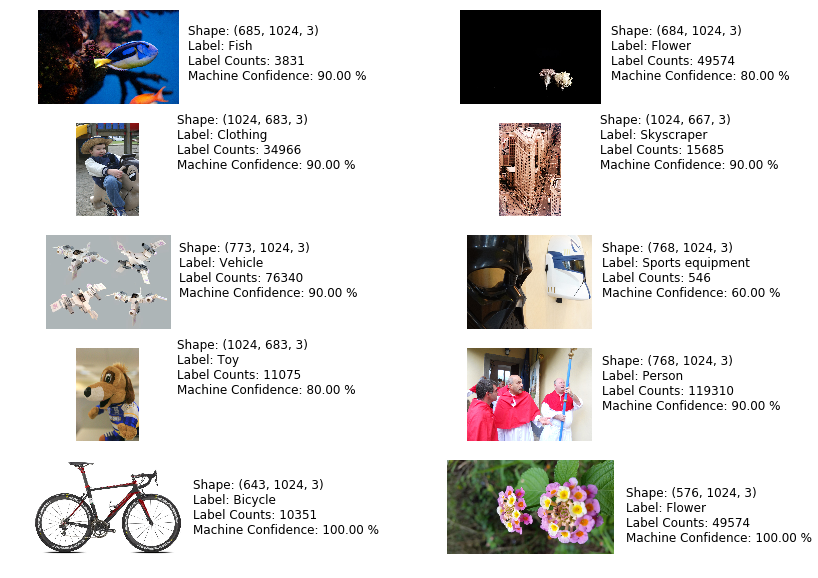

In [23]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10, 10))

for i in range(0, 10):
    plt.subplot(5, 2,1+i)
    plt.subplots_adjust(right=1.2)
    _ = plt.axis('off')
    rand_label_counts = label_total_counts[label_total_counts['ClassName'] == rand_label.values[i]]['Counts'].values
    machine_estimate = label_train_merge.iloc[indices[:]]['Confidence_Machine'].values * 100
    _ = plt.text(1100, 500, "Shape: {0}\nLabel: {1}\nLabel Counts: {2}\nMachine Confidence: {3:.2f} %".format(images_samples[i].shape, rand_label.values[i], rand_label_counts[0], machine_estimate[i]), 
             fontsize=12)
    _ = plt.imshow(images_samples[i])
    
plt.show()

I then obtained the statistics for the label counts.  Given the large maximum compared to the third quartile and the large standard deviation of the counts (approximately 9,122), I looked at the median value of 126.5, rather than at the mean value, and found the corresponding labels that had counts of 126 and 127. "Pillow" had a count of 126 and "Kite" had a count of 127 and thus could be considered the labels/ClassNames with the median frequencies.  

In [24]:
#Get statistics of label counts--large standard deviation and max compared to upper quartile
label_total_counts.describe()

,Counts
count,512.000000
mean,1874.857422
std,9122.328429
min,1.000000
25%,34.750000
50%,126.500000
75%,460.500000
max,119310.000000


In [25]:
#Labels Kite and Pillow both have approximately median counts
label_total_counts[(label_total_counts['Counts'] == 126) | (label_total_counts['Counts'] == 127)]

,ClassName,Counts
255,Kite,127
256,Pillow,126


I then plotted four views of the distribution of the label/ClassName data.  

First, I took the top 50 most frequent ClassNames and plotted them.  "Person" was by far the most frequent term, followed by "Tree" and "Vehicle", all fairly generic terms. As can be seen from the plot, the counts fall off fairly rapidly after the top 6-8 ClassNames, and all labels after "Bird" appear 20,000 or less times in the dataset.  

Then I took the remaining ClassNames, initially focusing on those with counts greater than 100, and then on every 250 entries in the dataset for greater clarity.  The former showed a much smoother decline in label frequencies over a wide variety of different types of labels, as also indicated by the much smaller standard deviation of 359.75.  Taking every 250th entry revealed a more choppy distribution of ClassName counts, but over a much smaller range; no count was much greater than 10.  

Finally, I plotted the bottom 50 least frequent ClassNames.  Again, none had a count much greater than 10.  The least frequent labels (at only one each) were "Cowboy hat", "Dishwasher", "Plastic bag", "Bicycle helmet", "Baseball bat" and "Carnivore", all fairly specific terms (with the possible exception of "Carnivore").  

After this analysis was concluded, I then prepared the data for machine learning.  

In [26]:
#Count numbers of each type of label--show top 50 only

top_labels = label_train_merge['ClassName'].value_counts()[0:50]

top_labels = top_labels.reset_index()

top_labels.columns = ['ClassName', 'Counts']

top_labels

,ClassName,Counts
0,Person,119310
1,Tree,91007
2,Vehicle,76340
3,Food,62492
4,Car,51533
5,Flower,49574
6,Building,38098
7,Clothing,34966
8,Bird,25170
9,House,21801


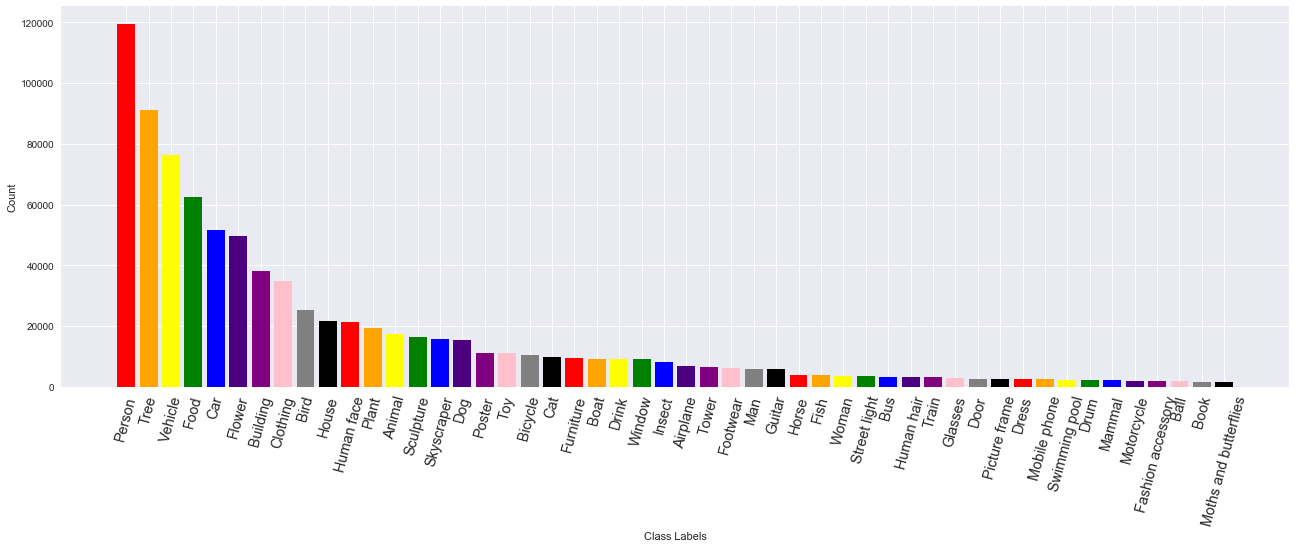

In [27]:
from matplotlib import pyplot as plt
import seaborn as sns

#Plot counts for 50 most common labels

sns.set()
fig, ax = plt.subplots()
fig.set_size_inches(22,7)
ax.set_xlabel('Class Labels')
ax.set_ylabel('Count')
ax.xaxis.set_tick_params(rotation=75, labelsize='large')
ax.set_xticklabels(top_labels['ClassName'])
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'purple', 'pink','gray', 'black']
plt.bar(top_labels['ClassName'], top_labels['Counts'], color=colors)

plt.show()

In [28]:
#Create mask of top label names and exclude from the rest to get the remainder

mask = [i for i in top_labels['ClassName']]
label_others = label_train_merge[~label_train_merge['ClassName'].isin(mask)]['ClassName']
label_others = pd.DataFrame(label_others, columns=['ClassName'])

#Confirm that remainder has proper amount--it is: 512-50=462
len(label_others['ClassName'].unique())

462

In [29]:
#Create dataframe of label counts for remaining labels for further examination
label_others['ClassName'].value_counts()
label_others_counts = pd.DataFrame(label_others['ClassName'].value_counts())
label_others_counts.columns = ['Counts']
label_others_counts['ClassName'] = label_others_counts.index
label_others_counts = label_others_counts.reset_index().drop('index', axis=1)
cols = ['ClassName', 'Counts']
label_others_counts = label_others_counts[cols]
label_others_counts.head()

,ClassName,Counts
0,Camera,1682
1,Aircraft,1645
2,Musical instrument,1556
3,Wheel,1544
4,Flag,1476


In [30]:
#Restrict label_others_counts for graphing purposes to counts greater than 100

other_labels = label_others_counts[label_others_counts['Counts'] > 100]
other_labels.describe()

,Counts
count,234.000000
mean,439.717949
std,359.754013
min,101.000000
25%,170.000000
50%,310.500000
75%,544.750000
max,1682.000000


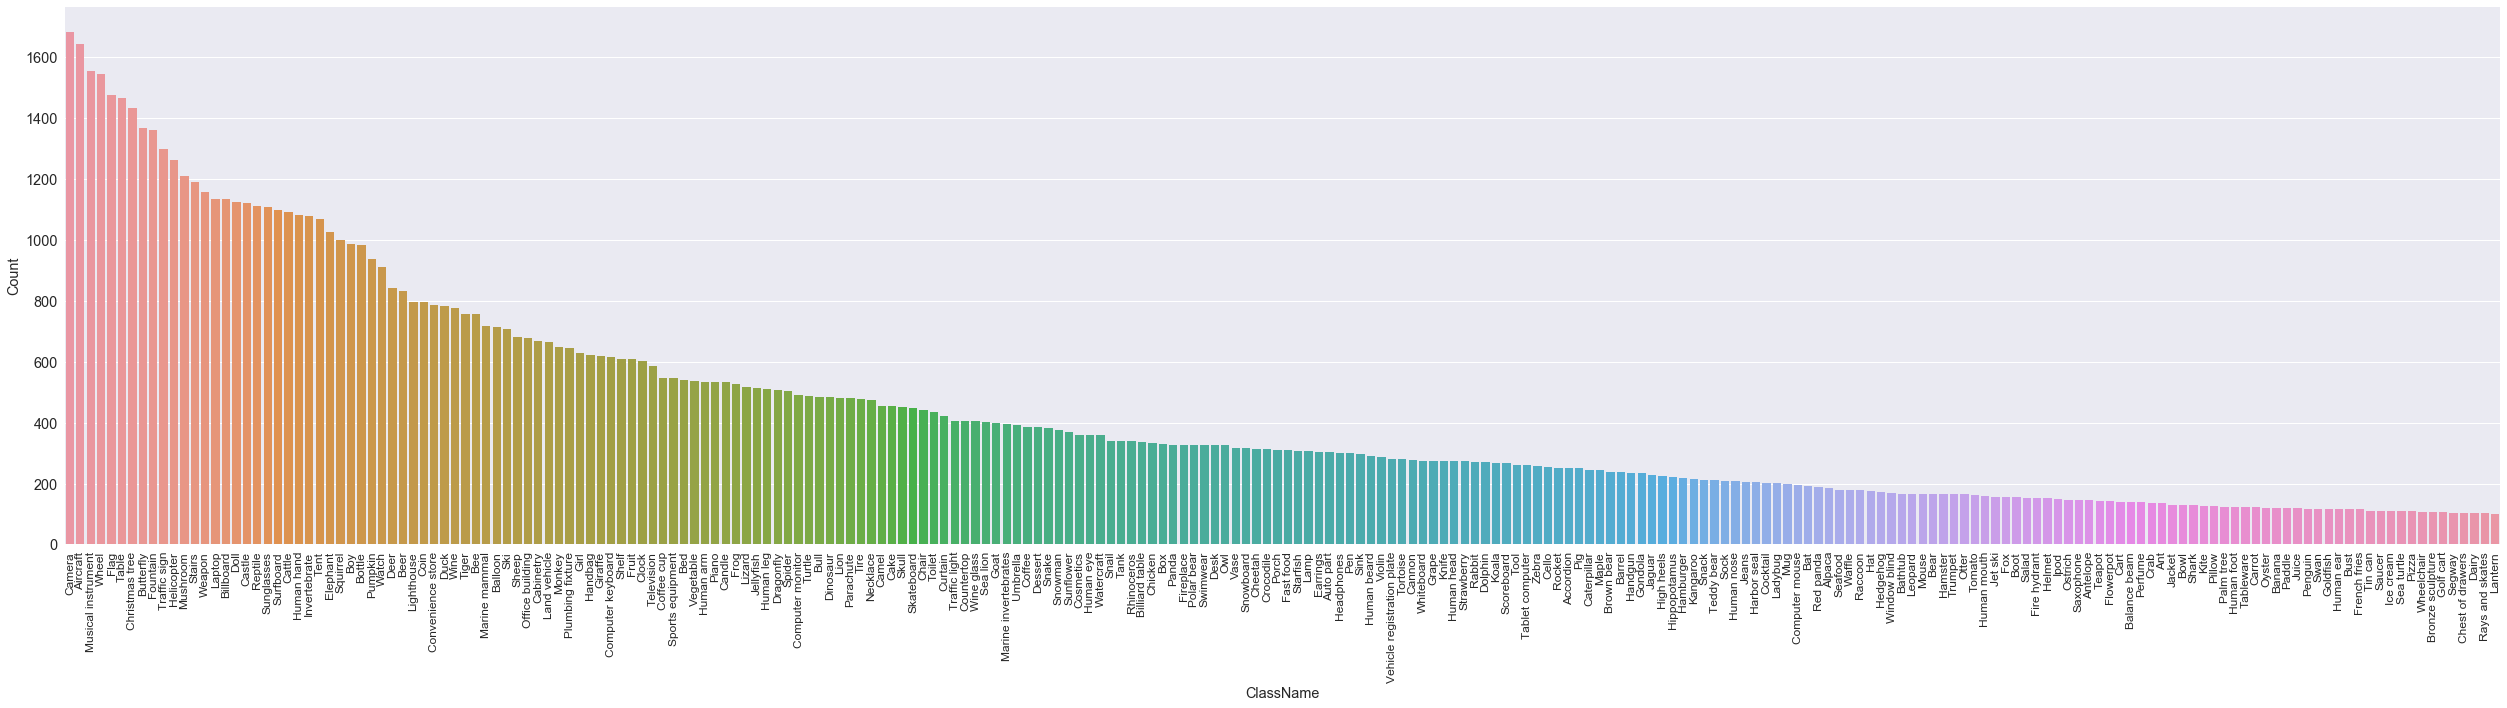

In [31]:
from matplotlib import pyplot as plt
import seaborn as sns

#Plot sample of counts for remaining labels, with greater than 100 instances each

sns.set()

fig, ax = plt.subplots()
fig.set_size_inches(35, 10)
ax.xaxis.set_tick_params(rotation=90, labelsize=12)
sns.barplot(x='ClassName', y='Counts', data=other_labels)
ax.set_ylabel('Count', size='large')
ax.yaxis.set_tick_params(labelsize='large')
ax.set_xlabel('ClassName', size='large')
plt.tight_layout()
plt.show()



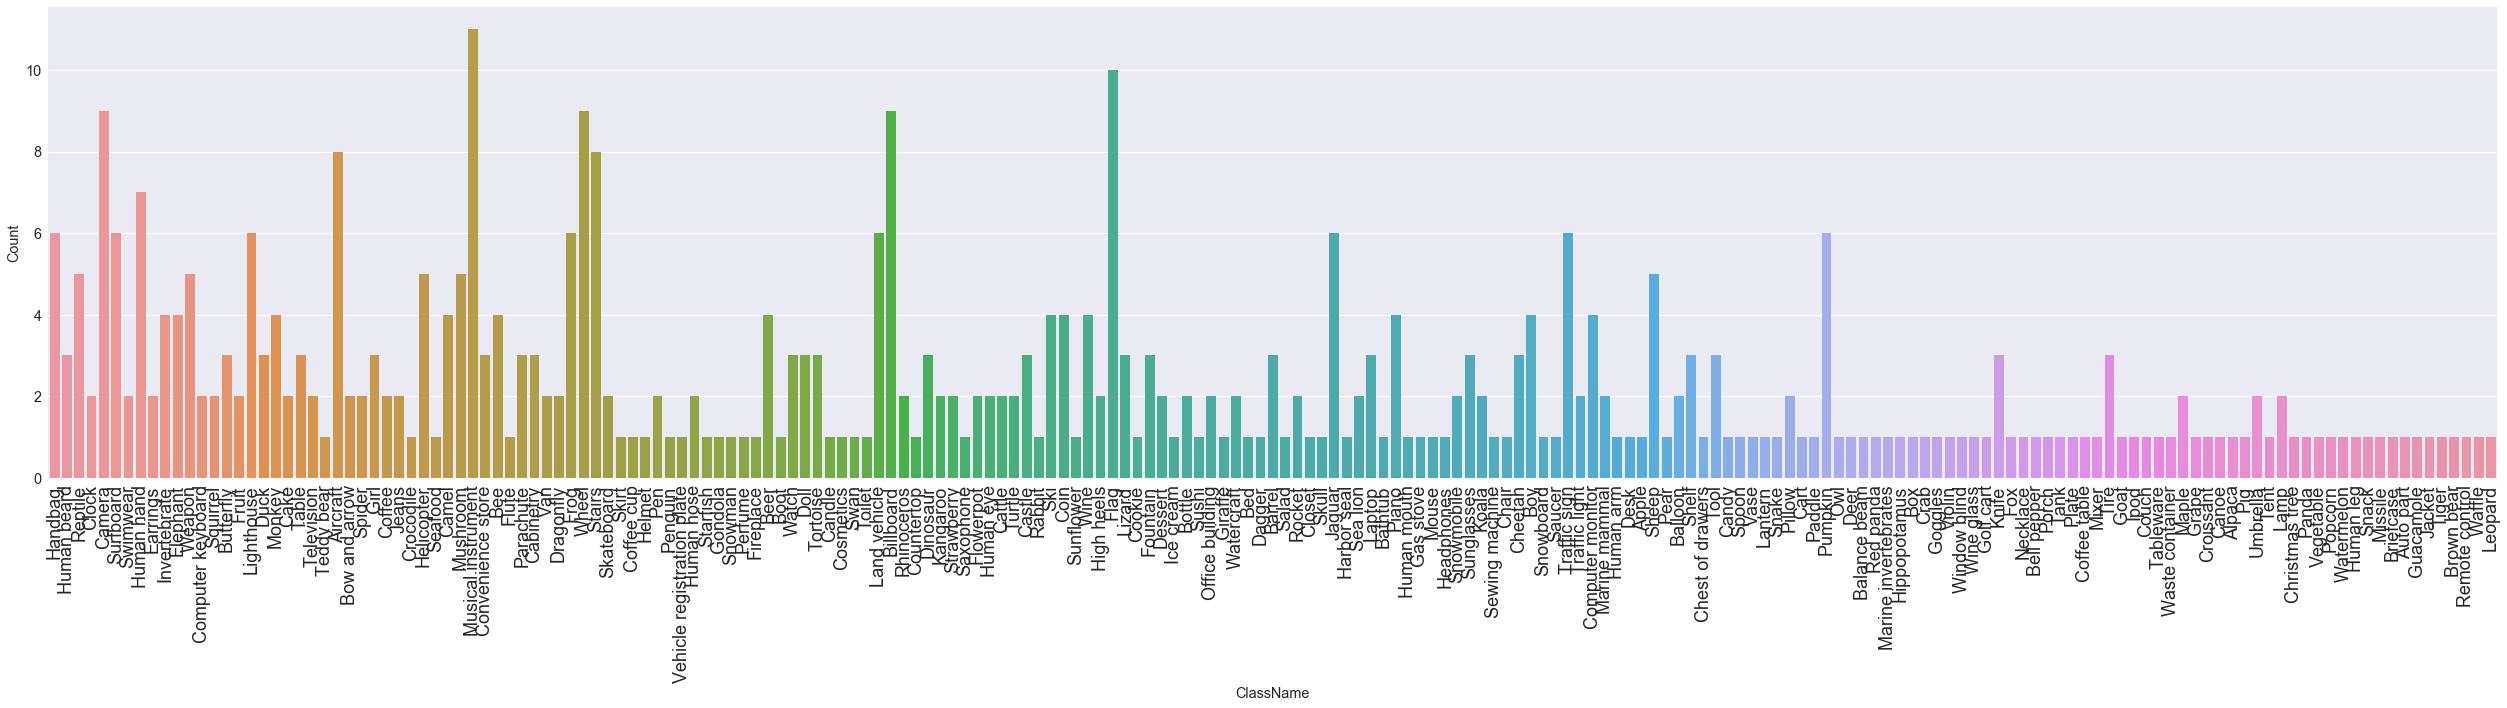

In [32]:
from matplotlib import pyplot as plt
import seaborn as sns

#Plot sample of counts for remaining labels, taking every 250 entries for greater readability

sns.set()

fig, ax = plt.subplots()
fig.set_size_inches(35, 10)
ax.xaxis.set_tick_params(rotation=90, labelsize=18)
sns.countplot(x='ClassName', data=label_others.iloc[::250])
ax.set_ylabel('Count', size='large')
ax.yaxis.set_tick_params(labelsize='large')
ax.set_xlabel('ClassName', size='large')
plt.tight_layout()
plt.show()


In [33]:
#Count numbers of each type of label--show lowest 50 only

bottom_labels = label_train_merge['ClassName'].value_counts()[-50:]

bottom_labels = bottom_labels.reset_index()

bottom_labels.columns = ['ClassName', 'Counts']

bottom_labels

,ClassName,Counts
0,Chainsaw,11
1,Armadillo,10
2,Towel,10
3,Envelope,10
4,Unicycle,10
5,Toothbrush,10
6,Tart,10
7,Drill,10
8,Frying pan,9
9,Wok,9


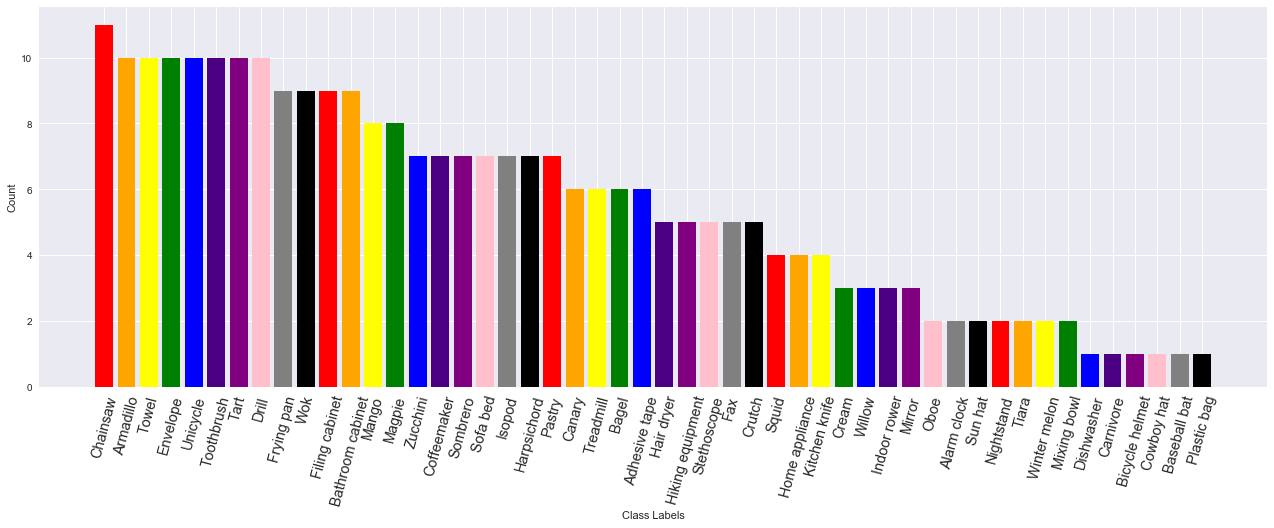

In [34]:
#Plot counts for 50 least common labels

sns.set()
fig, ax = plt.subplots()
fig.set_size_inches(22, 7)
ax.set_xlabel('Class Labels')
ax.set_ylabel('Count')
ax.xaxis.set_tick_params(rotation=75, labelsize='large')
ax.set_xticklabels(bottom_labels['ClassName'])
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'purple', 'pink','gray', 'black']
plt.bar(bottom_labels['ClassName'], bottom_labels['Counts'], color=colors)

plt.show()

## Machine Learning

### VGG16 Model

Given the inherent limitations of my hardware, I determined that transfer learning would be the best approach here to provide the greatest possible accuracy.  I initially attempted to adapt the VGG16 model to the present data using a standard input shape of (150, 150, 3), where 3 is the number of color channels. VGG16 is a convolutional neural network that had typically performed well on image classification tasks. In the present case I used a base model of VGG16 that was previously trained on the Imagenet dataset.  As can be seen below, the VGG16 base model consisted of two 2-dimensional convolutional layers followed by a max pooling layer repeated twice, followed by three 2-dimensional convolutional layers followed by a max pooling layer repeated three times. The final max pooling layer had dimensions of (4, 4, 512), which the final parts of the model I created below had to take as its input to "join" to the base model properly.   

In [35]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Using TensorFlow backend.


In [36]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

After setting up the VGG16 base model, I then used Keras' ImageDataGenerator to prepare the images for input to the network, rescaling them by 1/255.  I then created an extraction function called extract_features to pull the images and labels out together in appropriately sized batches using the new flow_from_dataframe function in Keras.  This function works in essentially the same way as the older flow_from_directory function in extracting images and their corresponding labels, but here the columns of a dataframe are used rather than the names of file folders in a directory.  In this case, the ImageID and ClassName columns in the label_train_merge dataframe were used and 5000 images (train_features) and labels (train_labels) were extracted and applied to the base VGG16 model (by predicting on the base model). Train_features was then reshaped into a (5000, 4, 4, 512) array in order to be input into the remainder of the model to be created below.  

Note: The extraction process is extremely lengthy, so the features and labels were pickled and should be loaded from the pickled file in order to save time.  

In [37]:
from keras.preprocessing.image import ImageDataGenerator
import os

ROOT_PATH = "/Volumes/Backup_Chris/Projects/Image_Recognition/"
train_data_dir = os.path.join(ROOT_PATH, "train")

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(dataframe, directory, sample_count):
    if directory == train_data_dir:
        features = np.zeros(shape=(sample_count, 4, 4, 512))
        labels = np.zeros(shape=(sample_count, 512))
        generator = datagen.flow_from_dataframe(dataframe=dataframe, directory=directory, 
                                           x_col="ImageID", y_col="ClassName", has_ext=False,
                                           target_size=(150, 150), batch_size=batch_size,
                                           seed=42, class_mode="categorical")
        i = 0
        for inputs_batch, labels_batch in generator:
            features_batch = conv_base.predict(inputs_batch)
            features[i * batch_size: (i + 1) * batch_size] = features_batch
            labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        
            i += 1
        
            if i * batch_size >= sample_count:
                break
    
        return features, labels
        


In [24]:
#Please use pickled file below for ease of use

train_features, train_labels = extract_features(label_train_merge, train_data_dir, 5000)


Found 959927 images belonging to 512 classes.


In [25]:
train_features = np.reshape(train_features, (5000, 4 * 4 * 512))


In [26]:
#Pickle extracted features and labels for VGG16 model for ease of use
#Write to file (do not use)
import pickle

#with open('extracts_train.pkl', 'wb') as f:
 #   pickle.dump([train_features, train_labels], f)
    


In [38]:
#Load pickled features and labels for VGG16 model
import pickle

with open('extracts_train.pkl', 'rb') as f:
    train_features, train_labels = pickle.load(f)
    

I then created the remainder of the model that took in values from the pre-trained VGG16 base model.  As can be seen below, it contains one dense layer with 256 channels/dimensions using the relu activation function(returning the input value itself for positive values and 0 for negative values), a dropout layer with 50% dropout (random disconnection of some neurons to compensate for any that may be dead/inactive) and one final dense layer using softmax activation (limiting the final output value to between 0 and 1 for classification purposes to obtain a probability) with 512 channels (one for each unique label). I compiled the model using the Adam optimizer with an initial learning rate of $2e^{-5}$ (Adam uses adaptive learning rates) and a loss function defined by categorical crossentropy (which grows larger when the difference between the predicted probability and 1 is large for a given label).  I also used a number of callbacks, including EarlyStopping to monitor the validation loss with a patience level of 3 (where 3 instances of non-declining validation loss is permitted during training before training is cut off).  Due to the imbalanced numbers of different labels noted in the statistical analysis above, I also set the class weights for the labels to "balanced", such that the size of the class weights would be set in inverse proportion to the label counts for each unique ClassName.  

In [39]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='softmax'))


In [40]:
from keras import optimizers

model.compile(optimizer=optimizers.Adam(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [41]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

callbacks = [TensorBoard(log_dir='logdir', histogram_freq=1), 
             EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [42]:
import numpy as np
from sklearn.utils import class_weight

y_ints = [y.argmax() for y in train_labels]

c_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_ints),
                                                 y_ints)



In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
Total params: 2,228,992
Trainable params: 2,228,992
Non-trainable params: 0
_________________________________________________________________


In [44]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, to_file='model.png')

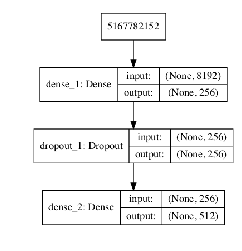

In [45]:
import matplotlib.pyplot as plt

mod_im = plt.imread('model.png')
plt.imshow(mod_im)
plt.axis('off')
plt.show()

I then trained the model using a 20% validation split, a batch size of 20 and 40 training epochs.  The validation accuracy was ultimately approximately 45%.  Although this was far from ideal, it was a marked improvement over an initial trial model without using transfer learning (not shown here) which ultimately had a validation accuracy that did not exceed 10%.  
  

In [9]:
from keras import models

np.random.seed(42)

history = model.fit(train_features, train_labels, epochs=40, batch_size=20, 
                   validation_split=0.2, class_weight=c_weights, callbacks=callbacks)


Train on 4000 samples, validate on 1000 samples
Epoch 1/40
4000/4000 [==============================] - 8s 2ms/step - loss: 5.4015 - acc: 0.1005 - val_loss: 4.4876 - val_acc: 0.1460
Epoch 2/40
4000/4000 [==============================] - 9s 2ms/step - loss: 4.3630 - acc: 0.1953 - val_loss: 3.8110 - val_acc: 0.2730
Epoch 3/40
4000/4000 [==============================] - 9s 2ms/step - loss: 3.8655 - acc: 0.2473 - val_loss: 3.4861 - val_acc: 0.3290
Epoch 4/40
4000/4000 [==============================] - 9s 2ms/step - loss: 3.5931 - acc: 0.2965 - val_loss: 3.3110 - val_acc: 0.3550
Epoch 5/40
4000/4000 [==============================] - 9s 2ms/step - loss: 3.3721 - acc: 0.3205 - val_loss: 3.1780 - val_acc: 0.3650
Epoch 6/40
4000/4000 [==============================] - 9s 2ms/step - loss: 3.2173 - acc: 0.3393 - val_loss: 3.1015 - val_acc: 0.3660
Epoch 7/40
4000/4000 [==============================] - 9s 2ms/step - loss: 3.0523 - acc: 0.3615 - val_loss: 3.0224 - val_acc: 0.3780
Epoch 8/40
400

In [10]:
from keras.models import load_model

#model.save('new_model_1.h5')

In [46]:
from keras.models import load_model
model = load_model('new_model_1.h5')


In [11]:
# Pickle the history file for the VGG16 model
# Write to file (do not use)

import pickle
#with open('history.pkl', 'wb') as f:
 #   pickle.dump(history, f)

In [47]:
#Read the pickled history file for the VGG16 model
import pickle

with open('history.pkl', 'rb') as f:
    history = pickle.load(f)

After saving the model for future use, I plotted the training and validation accuracy and loss, as shown below.  As can be observed, it was at or near the 9th or 10th epoch where the validation accuracy fell below the training accuracy and the validation loss rose above the training loss.  As can also be seen, the model was substantially overfitting by the end of training (64.83% training accuracy compared to 45.10% validation accuracy). Considering the foregoing issues, I abandoned this model in search of a better one.

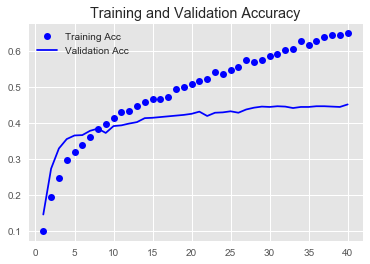

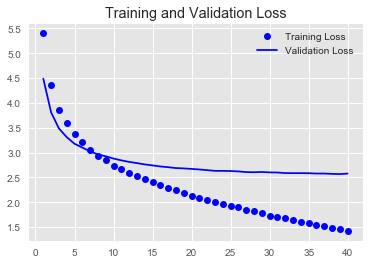

In [48]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.style.use('ggplot')

plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()

#plt.savefig('accuracy_vgg16.png')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

#plt.savefig('loss_vgg16.png')

plt.show()


### Xception Model I

I then decided to use an Xception model as the base model rather than VGG16. The Xception model uses separable convolutional layers to fully separate spatial and channel features of the input to make training both easier. It also uses residual connections such that some earlier layers are connected to later layers, bypassing some of the intervening layers. This type of model has proven highly effective on image classification tasks.  

I began by creating two alternative Xception base models, the first with the same image size that I used for the VGG16 model at (150, 150, 3), and the second with a larger image size of (299, 299, 3), a size that has been suggested as optimal for the Xception model.  I then created two separate feature/label extraction functions for each. The summary for both Xception base models are shown below.  Initially, I attempted to use the smaller image size in order to conserve processing power, and then extracted 5000 images and labels for training.  

**Note**:  The extraction functions take an extremely long time to run (45 minutes to an hour each), so it is recommended that the reader load the variables created by these functions from the pickled files in the section below following the cells where these functions are executed marked *Pickle Section* and follow the instructions given therein.   


In [49]:
from keras.applications import Xception

xception_conv_base = Xception(weights='imagenet', include_top=False, pooling='avg',input_shape=(150, 150, 3))

#Alternative base using more optimal image size
xcept_conv_base = Xception(weights='imagenet', include_top=False, pooling='avg',input_shape=(299, 299, 3))



In [50]:
#First base model summary
xception_conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [51]:
#Second base model summary with larger input images

xcept_conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [52]:
from keras.preprocessing.image import ImageDataGenerator
import os

ROOT_PATH = "/Volumes/Backup_Chris/Projects/Image_Recognition/"
train_data_dir = os.path.join(ROOT_PATH, "train")

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features_xception(dataframe, directory, sample_count, seed=42):
    if directory == train_data_dir:
        features = np.zeros(shape=(sample_count, 2048))
        labels = np.zeros(shape=(sample_count, 512))
        generator = datagen.flow_from_dataframe(dataframe=dataframe, directory=directory, 
                                           x_col="ImageID", y_col="ClassName", has_ext=False,
                                           target_size=(150, 150), batch_size=batch_size,
                                           seed=seed, class_mode="categorical")
        i = 0
        for inputs_batch, labels_batch in generator:
            features_batch = xception_conv_base.predict(inputs_batch)
            features[i * batch_size: (i + 1) * batch_size] = features_batch
            labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        
            i += 1
        
            if i * batch_size >= sample_count:
                break
    
        return features, labels
        
#Extraction function for alternative Xception model using larger image size

def extract_features_xcept(dataframe, directory, sample_count, seed=42):
    if directory == train_data_dir:
        features = np.zeros(shape=(sample_count, 2048))
        labels = np.zeros(shape=(sample_count, 512))
        generator = datagen.flow_from_dataframe(dataframe=dataframe, directory=directory, 
                                           x_col="ImageID", y_col="ClassName", has_ext=False,
                                           target_size=(299, 299), batch_size=batch_size,
                                           seed=seed, class_mode="categorical")
        i = 0
        for inputs_batch, labels_batch in generator:
            features_batch = xcept_conv_base.predict(inputs_batch)
            features[i * batch_size: (i + 1) * batch_size] = features_batch
            labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        
            i += 1
        
            if i * batch_size >= sample_count:
                break
    
        return features, labels



In [46]:
# For ease of use, please proceed to the area toward the bottom of the Pickle Section below 
# to load these variables. 

x_train_features, x_train_labels = extract_features_xception(label_train_merge, train_data_dir, 5000)


Found 959927 images belonging to 512 classes.


In [47]:
x_train_features = np.reshape(x_train_features, (5000, 2048))



In [35]:
#Train features and labels using alternative Xception model with larger image size

# For ease of use, please proceed to the area toward the top of the Pickle Section below 
# to load these variables. 

xC_train_features, xC_train_labels = extract_features_xcept(label_train_merge, train_data_dir, 12500)



Found 959927 images belonging to 512 classes.


In [37]:
xC_train_features = np.reshape(xC_train_features, (12500, 2048))


In [4]:
#Split xC_train features and labels into train (X) and test (y) sets using 80%-20% split

# If preferred, these variables may also be loaded from the pickled files at the bottom of 
# the Pickle Section below. However, random_state has been set here, so this should not be necessary.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(xC_train_features, xC_train_labels, test_size=0.2, random_state=42)



In [5]:
#Check that train and test sets have the proper size and number of channels

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)



(10000, 2048)
(10000, 512)
(2500, 2048)
(2500, 512)


#### *Pickle Section*

[*Since these extraction functions take an extremely long time to run (45 minutes to an hour each), it is recommended that the variables obtained be loaded from the pickled files below. The first files to be pickled were the larger image size features and labels that were ultimately used in the final model.  The smaller size image features and labels that were used initially were pickled afterward for later ease of use for illustrative purposes to compare and contrast with the results of training on the larger image size features and labels. Later, in the interest of caution, the training and testing sets for the larger image size features and labels were also pickled, but these need not be used.  The random state in the train_test_split function has been set, so the same train and test sets should be given whenever it is run.*]  

In [38]:
# Pickle features and labels with larger image size 
# Write to pickle file [do not use]
import pickle

#with open('extracts_xC.pkl', 'wb') as f:
 #   pickle.dump([xC_train_features, xC_train_labels], f)
    

In [53]:
# Pickle features and labels with larger image size 
# Read from pickle file 

import pickle

with open('extracts_xC.pkl', 'rb') as f:
    xC_train_features, xC_train_labels = pickle.load(f)



In [48]:
#Pickle original features and labels for later use for illustrative purposes
# Write to pickle file [do not use]

import pickle

#with open('extracts_x_train.pkl', 'wb') as f:
 #   pickle.dump([x_train_features, x_train_labels], f)
    

In [54]:
#Pickle original features and labels for later use for illustrative purposes
# Read from pickle file 

import pickle

with open('extracts_x_train.pkl', 'rb') as f:
    x_train_features, x_train_labels = pickle.load(f)

In [43]:
#Pickle train and test sets for larger image size features and labels
# Write to pickle file [do not use]

import pickle

#with open('train_XC.pkl', 'wb') as f:
 #   pickle.dump([X_train, y_train], f)
    
#with open('test_XC.pkl', 'wb') as f:
 #   pickle.dump([X_test, y_test], f)
    

In [55]:
#Pickle train set for larger image size features and labels
# Read from pickle file 

import pickle

with open('train_XC.pkl', 'rb') as f:
    X_train, y_train = pickle.load(f)



In [56]:
#Pickle test set for larger image size features and labels
# Read from pickle file 

import pickle

with open('test_XC.pkl', 'rb') as f:
    X_test, y_test = pickle.load(f)



 *End of Pickle Section*

I then created the final part of the model that took in the input that was processed by the base model called **x_model** with 2048 input channels to match the final number of output channels at the end of the base model.  It contained one dense layer with 1024 channels/dimensions using the relu activation function, a dropout layer with 50% dropout and one final dense layer using softmax activation with 512 channels (one for each unique label), i.e., a similar structure as the previous model's final part. 

In [57]:
from keras import models
from keras import layers
from keras import optimizers

x_model = models.Sequential()
x_model.add(layers.Dense(1024, activation='relu', input_dim=2048))
x_model.add(layers.Dropout(0.5))
x_model.add(layers.Dense(512, activation='softmax'))

In [58]:
x_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
Total params: 2,622,976
Trainable params: 2,622,976
Non-trainable params: 0
_________________________________________________________________


In [59]:
from keras.utils import plot_model

plot_model(x_model, show_shapes=True, to_file='x_model.png')

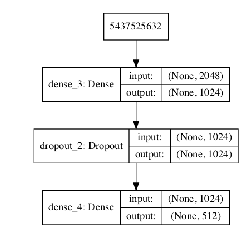

In [60]:
import matplotlib.pyplot as plt

mod_im = plt.imread('x_model.png')
plt.imshow(mod_im)
plt.axis('off')
plt.show()

I compiled the model using the Adam optimizer with the same initial learning rate of $2e^{-5}$ as before and a categorical crossentropy loss function.  I also used the same callbacks and class weight balancing as before. 

In [61]:
from keras import optimizers

x_model.compile(optimizer=optimizers.Adam(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])



In [62]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

callbacks_x = [TensorBoard(log_dir='logdir', histogram_freq=1), 
             EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='best_x_model.h5', monitor='val_loss', save_best_only=True)]

In [63]:
import numpy as np
from sklearn.utils import class_weight

y_ints_x = [y.argmax() for y in x_train_labels]


c_weights_x = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_ints_x),
                                                 y_ints_x)



I then trained the model using a 20% validation split, a batch size of 20 and 40 training epochs, as before.  The validation accuracy improved here to approximately 58%. (The final validation accuracy was 57.50% after stopping at the 35th epoch due to Early Stopping.)


In [19]:
from keras import models

np.random.seed(42)

history_x = x_model.fit(x_train_features, x_train_labels, epochs=40, batch_size=20, 
                   validation_split=0.2, class_weight=c_weights_x, callbacks=callbacks_x)



Train on 4000 samples, validate on 1000 samples
Epoch 1/40
4000/4000 [==============================] - 10s 3ms/step - loss: 5.1302 - acc: 0.1683 - val_loss: 4.0685 - val_acc: 0.3360
Epoch 2/40
4000/4000 [==============================] - 11s 3ms/step - loss: 3.7334 - acc: 0.3625 - val_loss: 3.3680 - val_acc: 0.4180
Epoch 3/40
4000/4000 [==============================] - 11s 3ms/step - loss: 3.1973 - acc: 0.4078 - val_loss: 3.0390 - val_acc: 0.4480
Epoch 4/40
4000/4000 [==============================] - 11s 3ms/step - loss: 2.8491 - acc: 0.4515 - val_loss: 2.8339 - val_acc: 0.4910
Epoch 5/40
4000/4000 [==============================] - 11s 3ms/step - loss: 2.6262 - acc: 0.4790 - val_loss: 2.6907 - val_acc: 0.5030
Epoch 6/40
4000/4000 [==============================] - 11s 3ms/step - loss: 2.4256 - acc: 0.5045 - val_loss: 2.5886 - val_acc: 0.5140
Epoch 7/40
4000/4000 [==============================] - 11s 3ms/step - loss: 2.2700 - acc: 0.5295 - val_loss: 2.5049 - val_acc: 0.5210 loss: 2

In [20]:
#Save first Xception model 
from keras.models import load_model

#x_model.save('new_model_x.h5')

In [64]:
#Load first Xception model
from keras.models import load_model

x_model = load_model('new_model_x.h5')

In [21]:
# Pickle the history file for the x_model
# Write to file (do not use)

import pickle
#with open('hist_x.pkl', 'wb') as f:
 #   pickle.dump(history_x, f)

In [65]:
#Read the pickled history file for the x_model
import pickle

with open('hist_x.pkl', 'rb') as f:
    history_x = pickle.load(f)


After saving the model for future use, I plotted the training and validation accuracy and loss, as shown below.  As can be observed, it was at or near the 6th or 7th epoch where the validation accuracy fell below the training accuracy and the validation loss rose above the training loss.  As can also be seen, the model was again substantially overfitting by the end of training (83.15% training accuracy compared to 57.50% validation accuracy).  

I then decided to keep the Xception model due to the substantially improved results.  However, in order to further improve the model's accuracy, I decided to make additional changes, including using the alternative Xception base model. 


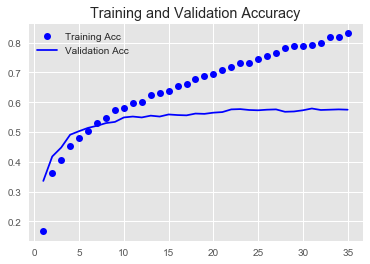

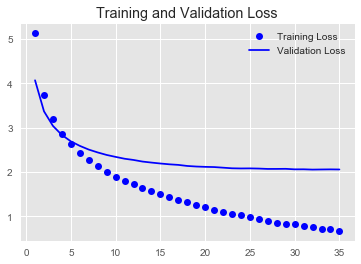

In [66]:
import matplotlib.pyplot as plt

acc = history_x.history['acc']
val_acc = history_x.history['val_acc']
loss = history_x.history['loss']
val_loss = history_x.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.style.use('ggplot')

plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()

#plt.savefig('accuracy_x.png')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

#plt.savefig('loss_x.png')

plt.show()



### Hyperparameter Optimization Attempts

Before attempting to use the Xception model with larger image sizes, I attempted to adjust some of the hyperparameters in the existing model.  First, I used a package called Hyperas that allows one to set the hyperparameters for the system to optimize.  The package then issues recommendations for each of the chosen hyperparameters.  However, these recommendations did not provide an adequate improvement in validation accuracy.  I then attempted to use another optimization package called Talos.  Talos performs an extensive scan of the model over all of the hyperparameters, including the number of channels used in each layer of the network, a process that took just a little under 5 hours.  Unfortunately, the model produced as a result of implementing its recommendations performed extremely poorly.  It may be that such optimization packages were not necessarily designed to be used in a transfer learning context, where they are not seeing the base model that the data was pre-trained on, and instead must scan over the full model.  

### Xception Model II

In any event, after the poor performance of both optimization packages, I decided to use the alternative Xception base model using the larger image size of (299, 299, 3), since this also happened to be the recommended image size for the Xception model.  I also decided to increase the number of images used in training the data.  By giving the model more data to train on, I hoped this would improve its accuracy.  Instead of extracting 5000 images and labels as before, I extracted 12,500 total images and labels which were then split into a train and test set using the train_test_split function using an 80%-20% split such that the training set consisted of 10,000 images and labels, while the test set consisted of 2500 images and labels (ensuring that the test set had the same number of unique class names as the training set at 512 each).  

I then created the final part of the model that took in the input that was processed by the new Xception base model called **xC_model** with 2048 input channels to match the final number of output channels at the end of the base model.  It contained one dense layer with 1024 channels/dimensions using the relu activation function, a dropout layer with 50% dropout and one final dense layer using softmax activation with 512 channels (one for each unique label), i.e., again, a similar structure as both of the previous models' final parts. 

I then compiled the model using the Adam optimizer with an initial learning rate of 0.00001 (based in part on some of the suggestions given during the hyperparameter optimization process combined with personal experimentation) and a categorical crossentropy loss function.  I also used the same callbacks and class weight balancing as before. 

In [67]:
import keras.utils
from keras import models
from keras import layers
from keras import optimizers

#Implement alternative Xception model with larger image sizes

xC_model = models.Sequential()
xC_model.add(layers.Dense(1024, activation='relu', input_dim=2048))
xC_model.add(layers.Dropout(0.5))
xC_model.add(layers.Dense(512, activation='softmax'))  



In [68]:
xC_model.compile(optimizer=optimizers.Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])



In [69]:
xC_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
Total params: 2,622,976
Trainable params: 2,622,976
Non-trainable params: 0
_________________________________________________________________


In [70]:
from keras.utils import plot_model

plot_model(xC_model, show_shapes=True, to_file='xC_model.png')

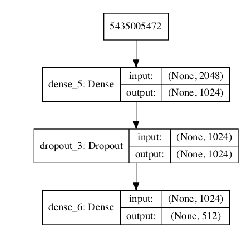

In [71]:
import matplotlib.pyplot as plt

mod_im = plt.imread('xC_model.png')
plt.imshow(mod_im)
plt.axis('off')
plt.show()


In [72]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

callbacks_xC = [TensorBoard(log_dir='logdir_XC', histogram_freq=1), 
             EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='best_xC_model.h5', monitor='val_loss', save_best_only=True)]

In [73]:
import numpy as np
from sklearn.utils import class_weight

y_ints_xC = [y.argmax() for y in y_train]

c_weights_xC = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_ints_xC),
                                                 y_ints_xC)

I then trained the model using a 20% validation split (such that 8000 samples would be used for training, twice the number used in the two previous models), a batch size of 20 and 70 training epochs.  The validation accuracy improved here substantially to approximately 69%. The final validation accuracy was 69.05% at the 70th epoch.  The Early Stopping callback was not implemented here, as the validation loss showed continuous improvement throughout the training process.  However, although I started at the previous 40 training epochs and increased it to 70 when I saw that further improvement was possible, the validation accuracy appeared to be leveling off here to a point where no substantial further improvement was likely.   

In [10]:
np.random.seed(42)

history_xC = xC_model.fit(X_train, y_train, epochs=70, batch_size=20, 
                   validation_split=0.2, callbacks=callbacks_xC, class_weight=c_weights_xC)



Train on 8000 samples, validate on 2000 samples
Epoch 1/70
8000/8000 [==============================] - 27s 3ms/step - loss: 5.2539 - acc: 0.1520 - val_loss: 4.2133 - val_acc: 0.2000
Epoch 2/70
8000/8000 [==============================] - 32s 4ms/step - loss: 3.7624 - acc: 0.2968 - val_loss: 3.4007 - val_acc: 0.4185
Epoch 3/70
8000/8000 [==============================] - 28s 3ms/step - loss: 3.2164 - acc: 0.3994 - val_loss: 3.0540 - val_acc: 0.4550
Epoch 4/70
8000/8000 [==============================] - 28s 3ms/step - loss: 2.9232 - acc: 0.4404 - val_loss: 2.8283 - val_acc: 0.4765
Epoch 5/70
8000/8000 [==============================] - 28s 3ms/step - loss: 2.7163 - acc: 0.4769 - val_loss: 2.6639 - val_acc: 0.5110
Epoch 6/70
8000/8000 [==============================] - 28s 4ms/step - loss: 2.5307 - acc: 0.5061 - val_loss: 2.5320 - val_acc: 0.5315
Epoch 7/70
8000/8000 [==============================] - 28s 4ms/step - loss: 2.3958 - acc: 0.5333 - val_loss: 2.4266 - val_acc: 0.5440
Epoch 8

In [11]:
# Save the model
from keras.models import load_model

#xC_model.save('new_model_xC.h5')

In [12]:
# Pickle the history file for the xC_model
# Write to file (do not use)

import pickle
#with open('hist_XC.pkl', 'wb') as f:
 #   pickle.dump(history_xC, f)

In [74]:
#Load the xC_model

from keras.models import load_model

xC_model = load_model('new_model_xC.h5') 

In [75]:
#Read the pickled history file for the xC_model
import pickle

with open('hist_XC.pkl', 'rb') as f:
    history_xC = pickle.load(f)


After saving this model and its history file for future use, I plotted the training and validation accuracy and loss, as shown below.  As can be observed, it was at or near the 15th epoch where the validation accuracy fell below the training accuracy and the validation loss rose above the training loss (substantially later than in the previous models).  As can also be seen, although the model was again overfitting by the end of training, the degree of overfitting was substantially less than it had been in previous models (80.88% training accuracy compared to 69.05% validation accuracy).  


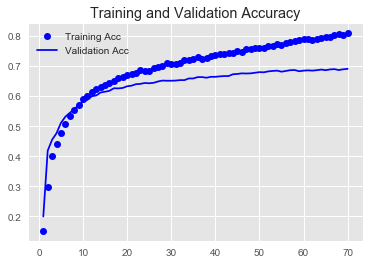

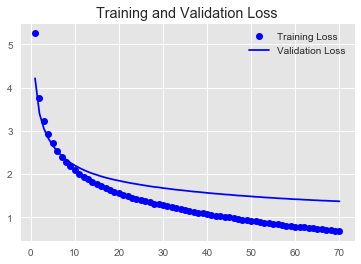

In [76]:
import matplotlib.pyplot as plt

acc = history_xC.history['acc']
val_acc = history_xC.history['val_acc']
loss = history_xC.history['loss']
val_loss = history_xC.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.style.use('ggplot')

plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()

#plt.savefig('accuracy_XC.png')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

#plt.savefig('loss_XC.png')

plt.show()



I then ran the score for the test set data using the evaluate function and the testing accuracy was 66.64%, fairly close to the validation accuracy of 69.05%. As this appeared to be a positive sign, I also ran the classification report for this model in order to get precision, recall and F1 scores.  

The overall (average) precision, recall and F1 scores were close to the test accuracy; the precision was .61, the recall was .67 and the F1 score (the harmonic mean of the precision and recall) was .63.  Thus, the model correctly predicted a given label 61% of the time the model predicted the given label as being applicable (the model's precision), and the model correctly predicted the label 67% of the time that the given label was actually applicable to the given image (the model's recall). These results were thus reasonably positive to warrant further investigation of this model.

Additionally, it should be noted in the classification report below that the foregoing scores for the individual labels/ClassNames varied greatly depending in part upon their ubiquity in the dataset. Some of the less frequent labels were not predicted by the model at all, and thus appear as zeros here.  In other instances the model simply appeared better at classifying certain types of images over others.  For example, the model correctly predicted "Cat" images with precision and recall of .92 each, while the model's predictions for "Helicopter" images were inconsistently predicted with a poor precision of .43, but a reasonably good recall of .77. However, there were 36 "Cat" images in the test set and only 13 "Helicopter" images.  Other images, such as "Building" images, had precision and recall scores more closely matching the overall precision and recall scores (.61 and .75, respectively), where there were 93 "Building" images in the test set. 

Thus, although the frequency of the particular type of image appears to have had some influence on the precision and recall scores, it does not appear to have been the only factor and may also have been influenced by how well the base convolutional model was pre-trained on these types of images as well as by any peculiarities in these particular test images and by how well the filters in the convolutional layers of the present model may have responded to these peculiarities.   

In [77]:
#Get accuracy score on test set data

score = xC_model.evaluate(X_test, y_test, batch_size=20)

print(score)
print("Accuracy: {:.2f}".format(score[1] * 100), "%")

2500/2500 [==============================] - 1s 536us/step
[1.4172375373840331, 0.6663999979496003]
Accuracy: 66.64 %


In [78]:
#Classification Report
from sklearn.metrics import classification_report

targ_names = label_train_merge.ClassName.unique()

preds = xC_model.predict(X_test, batch_size=20)

report = classification_report(y_test.argmax(axis=1), preds.argmax(axis=1), target_names=targ_names)

print(report)

                            precision    recall  f1-score   support

                  Building       0.61      0.75      0.67        93
                       Car       0.88      0.86      0.87       142
                    Person       0.68      0.85      0.76       302
                 Sculpture       0.80      0.82      0.81        44
                   Vehicle       0.57      0.74      0.65       206
                 Furniture       0.44      0.71      0.54        24
                      Tree       0.71      0.85      0.78       205
                Human hair       0.00      0.00      0.00         6
                  Clothing       0.48      0.57      0.52        77
                      Food       0.76      0.90      0.82       170
                Skyscraper       0.72      0.66      0.69        35
                   Handbag       0.00      0.00      0.00         1
                       Toy       0.66      0.66      0.66        29
                    Mammal       0.00      0.00

/Users/christophervolk/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 224, does not match size of target_names, 512
  .format(len(labels), len(target_names))
/Users/christophervolk/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/christophervolk/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### Random Image Sampling and Testing

I then prepared to sample 10 random images from the test set and apply the model to them to compare the predicted labels, the probability with which the model predicted those labels, the true labels, and the machine confidence/probability that a prior machine learning model predicted for the true labels.  However, some of this information (the machine confidence) needed to be drawn from the original dataframe.  Therefore I needed to be able to match up the ImageID's (and corresponding machine confidences) drawn from the original dataframe with the 10 randomly drawn images from the test set, which was randomly split from the group of 12,500 images that was itself randomly drawn from the original dataframe. Accordingly, I proceeded as follows:

##### Equivalent Random Sampling of Test Images and the Dataframe

First, I created a new function called **reextract_images** similar to the extract_images functions used above that were used to process the images from the original dataframe through the base pre-trained convolutional models, only this time I did not put them through any of the base models.  I also created a function called **deprocess_image** that would undo the preliminary image processing used after flowing the images from the dataframe in order to restore them to a state such that they can readily be viewed.  

I ran the reextract_images function to draw out 12,500 images and labels using the same random seed as I did when I used extract_features_xcept to draw the original 12,500 images and labels for use in the final Xception model.  

In [79]:
from keras.preprocessing.image import ImageDataGenerator
import os

ROOT_PATH = "/Volumes/Backup_Chris/Projects/Image_Recognition/"
train_data_dir = os.path.join(ROOT_PATH, "train")

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def reextract_images(dataframe, directory, sample_count, seed=42):
    if directory == train_data_dir:
        features = np.zeros(shape=(sample_count, 299, 299, 3))
        labels = np.zeros(shape=(sample_count, 512))
        generator = datagen.flow_from_dataframe(dataframe=dataframe, directory=directory, 
                                           x_col="ImageID", y_col="ClassName", has_ext=False,
                                           target_size=(299, 299), batch_size=batch_size,
                                           seed=seed, class_mode="categorical")
        i = 0
        for inputs_batch, labels_batch in generator:
            features[i * batch_size: (i + 1) * batch_size] = inputs_batch
            labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        
            i += 1
        
            if i * batch_size >= sample_count:
                break
    
        return features, labels


def deprocess_image(x):
    x = np.array(x)
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x*= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x


In [27]:
#Do not run--please load the deprocessed im_test_features and im_test_labels variables from
# joblib below

#Reextract images and labels from the dataframe as originally done for the final Xception model
testXC_reextract, testXC_labels_reextract = reextract_images(label_train_merge, train_data_dir, 12500)



Found 959927 images belonging to 512 classes.


I then used train_test_split to split the reextracted features and labels into training and testing sets using an 80%-20% split and the same random_state as used when I first created the training and testing sets for the final Xception model above.  

I then saved the test features and labels in a joblib file for later ease of loading since the reextract function also takes a very long time to execute (approximately 45-50 minutes). (The training set was not needed here since we are only going to be applying the model to sample test images, so only the test set was saved.)  Since the images were not processed as they had been for the model, they are even larger and so were too large to be saved in a pickle file.  Joblib allowed both the images and labels to be succesfully saved in a single joblib file. 


In [33]:
#Do not run--please load the deprocessed im_test_features and im_test_labels variables from
# joblib below

#Split the rextracted images and labels using the same 80%-20% split and random_state 
#as used in the final Xception model
from sklearn.model_selection import train_test_split

im_trn_features, im_test_features, im_trn_labels, im_test_labels = train_test_split(testXC_reextract, testXC_labels_reextract, test_size=0.2, random_state=42)


In [45]:
import pickle
import os
from sklearn.externals import joblib

#joblib.dump([im_test_features, im_test_labels], 'im_test_XC.joblib') 


['im_test_XC.joblib']

In [80]:
#Load reextracted images and labels from joblib file--use these variables going forward
from sklearn.externals import joblib

im_test_f, im_test_l = joblib.load('im_test_XC.joblib')

At this point I used random.sample to choose 10 random indices ( called **sample_indices**) from the reextracted test images and created **sample_images** and **sample_labels** by filtering based on these indices.  Then, using the same random seed, I used random.choice to create **rand_indices** which would allow me to filter the original dataframe to obtain the ImageID's and ClassNames corresponding to the same 12,500 images and labels that I obtained through the extraction and reextraction processes.  



In [81]:
# Pick 10 random images
import random
random.seed(42)

sample_indices = random.sample(range(len(im_test_f)), 10)
sample_images = [im_test_f[i] for i in sample_indices]
sample_labels = [im_test_l[i] for i in sample_indices]



In [82]:
#Get indices from dataframe corresponding to random images taken in rextraction using same seed
np.random.seed(42)
rand_indices = np.random.choice(label_train_merge.index, 12500, replace=False)



Next, using train_test_split, I split the dataframe variables in the same way as the images and labels had been split earlier, i.e., using an 80%-20% split with the same random_state.  The "training set" here was again discarded since we are now only interested in sampling the test set, called **df_test_features** and **df_test_labels**.  After this, df_test_labels was filtered using the sample_indices created earlier to obtain dataframe entries corresponding to the same 10 random images and labels sampled earlier (called **machine_indices**). 

In [83]:
#Split the dataframe indexed by rand_indices the via train-test-split using the same seed and 
#percent split to get the corresponding entries in the dataframe
from sklearn.model_selection import train_test_split

df_trn_features, df_test_features, df_trn_labels, df_test_labels = train_test_split(label_train_merge['ImageID'][rand_indices], label_train_merge['ClassName'][rand_indices], test_size=0.2, random_state=42)




In order to confirm that the random labels chosen correspond to the same randomly chosen ClassName entries in the dataframe, I compared the ClassName variable filtered by the sample_indices in the dataframe to the random extracted labels and found them to be a match. (Specifically, (label_train_merge['ClassName'][machine_indices].values ==[targ_names[sample_labels[i].argmax()] for i in range(0, 10)]).all() yielded 'True'.)  Accordingly, I knew that I would be able to obtain the corresponding machine_confidence percentages when evaluating the sample test images.  

In [84]:
#Index test labels in the dataframe using the sample indexes to get corresponding indices 
#in the dataframe and then index the total dataframe to get the corresponding Machine Confidences 
#for each label (testing on 'ClassName' and comparing  to sample_labels shows they are identical 
#and the method works to obtain the corresponding dataframe values from randomly produced images/labels.)

machine_indices = df_test_labels.iloc[sample_indices].index

machine_confidence = label_train_merge['Confidence_Machine'][machine_indices]

#Test effectiveness of retrieval of dataframe indices from randomly drawn images and labels 
#on labels--they match
(label_train_merge['ClassName'][machine_indices].values == 
 [targ_names[sample_labels[i].argmax()] for i in range(0, 10)]).all()

True

##### Sample Image Deprocessing, Viewing and Evaluation

I then used the deprocess_image function on the sample_images to bring them back to the proper form for viewing.  Their shape was shown to be (10, 299, 299, 3), indicating 10 image arrays of shape (299, 299, 3) which is the proper shape for each.  

To obtain the predicted classes and probabilities I used the predict_classes and predict functions on the processed test features previously obtained above (X_test) filtered by the sample_indices to obtain the correct predictions for the corresponding processed images.  

Then I plotted all ten of the sample images in reduced form along with their true labels, predicted labels, probabilities as given by the xC_model and their machine_confidences as given by theoriginal dataframe.  Correct predictions appear in green, while incorrect predictions are in red.  

Half of the sample images were correctly labeled by the model.  These images were of a flower, two houses, an animal and a person.  All of the true labels had machine confidences of 80.00% or greater. Only the animal (apparently a monkey) had a model prediction probability of less than 50%, which also corresponded to the lowest machine confidence of 80.00%.  The monkey appears in a crouched position in the image and so this unusual posture could have been responsible for the model's lower confidence in predicting this label correctly, despite its ultimate success in doing so.  The first of the "House" images also had a low model prediction probability of 56.54%, perhaps because this image was of the interior of the house.  (Machine confidence in this label was at 90.00%, however).  The second "House" image was of the exterior of a house, and here the model predicted this label correctly with a greater probability of 89.70% (again with a machine confidence of 90.00%). Generally, though, the correctly classified images were classified with both high model and machine confidence levels (90-100%).  

However, as can be seen below, even the incorrect predictions are incorrect only in the most literal sense that the true and predicted labels did not match precisely. For example, in the image of the train, the model predicted "Train" with a low 55.08% probability, but the true label was "Vehicle" given by a 70.00% machine confidence, the lowest machine confidence shown here.  Obviously, a train is a vehicle so both labels are technically correct. The same logic applies to the apparent error in classifying the image of the boat.  

In the image of the woman wearing glasses, the model predicted "Human face" with a 41.02% probability (the lowest model probability for these samples), but the true label was "Glasses" given by a 90.00% machine confidence.  While these labels are not synonyms, both a human face and glasses are present in the image.  Thus, this error would appear to be an artifact of the dataframe reduction process in which the dataset was reduced from multiple labels per image to a single label per image since both labels apply equally well to this image.  The same logic applies to the apparent error in classifying the image of the man in the sweat jacket holding the bottle.  The image is both of "Clothing" (the true label) and of a "Person" (the predicted label).  

The more difficult error to resolve is that involving the image of the two animals, predicted as "Dog" by the model, but having the true label "Cat".  This prediction was made with a 92.25% probability by the model and the true label had a 100% machine confidence.  In order to analyze this error further, I plotted the image again separately and at a larger size for greater clarity.  As can be seen in the larger image below, the animal in black and white fur is definitely a cat, but the other animal in orange and white fur appears to be either another larger cat or perhaps a small dog.  It is therefore understandable that the model may not have classified this image correctly.  

In any event, it appears that the xC_model did very well in classifying these sample images, and in truth actually performed better than its 66.64% test accuracy score would suggest. In instances of apparent prediction error in classifying the sample images, the true label was either a synonym of the predicted label or both the true label and predicted label were equally applicable to the relevant image. 


In [85]:
#Deprocess sample images for viewing
im_test = deprocess_image(sample_images)

im_test.shape

(10, 299, 299, 3)

In [86]:
#Get class predictions and probabilities from the xC_model for the sample test images

pred_classes = xC_model.predict_classes(X_test[sample_indices])
pred_prob = xC_model.predict(X_test[sample_indices])


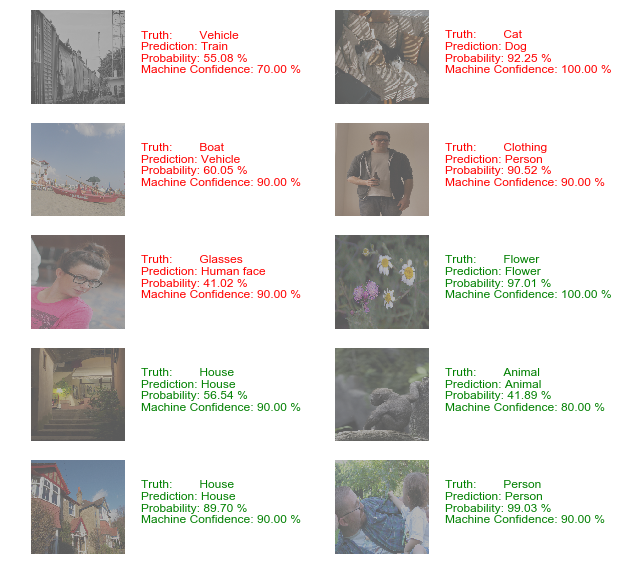

In [87]:
# Show the inputs and predicted outputs

from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10, 10))

for i in range(0, 10):
    truth = targ_names[sample_labels[i].argmax()]
    prediction = targ_names[pred_classes[i]]
    prob = pred_prob[i].max() * 100
    machine_prob = machine_confidence.iloc[i] * 100
    plt.subplot(5, 2,1+i)
    _ = plt.axis('off')
    color='green' if truth == prediction else 'red'
    _ = plt.text(350, 200, "Truth:        {0}\nPrediction: {1}\nProbability: {2:.2f} %\nMachine Confidence: {3:.2f} %".format(truth, prediction, prob, machine_prob), 
             fontsize=12, color=color)
    _ = plt.imshow(im_test[i])

    
plt.show()



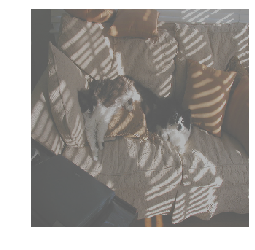

In [88]:
#Show a closeup of the two animals in the picture with the only apparent 
#total error (Cat vs. Dog).  Closeup reveals what appears to be a cat and a dog sitting 
#together, thus minimizing this error as well.  

from matplotlib import pyplot as plt

plt.imshow(im_test[1])
plt.axis('off')
plt.show()

## Concluding Remarks and Recommendations

While the model that was ultimately used here proved to be accurate to a large extent, there is still room for additional improvement. First, after experimenting with different types of convolutional models (VGG16 and Xception), tuning various hyperparameters and experimenting with the size and number of the input images, it appears that the greatest factors contributing to the accuracy of the model were the number of input images, followed by the type of convolutional model and the size of the input images used.  (Tuning the hyperparameters by themselves provided only modest gains in model performance at best, and in some instances had almost no impact at all.)   

The Xception model proved to be superior to the VGG16 model, at least in the present instance, and using the recommended input image size for the Xception model provided further benefits.  However, substantially increasing the number of input images appeared to provide the greatest gains in accuracy.  I achieved an approximately 11.5% increase in validation accuracy by doubling the number of training images from 4000 (after withholding 1000 images for validation) to 8000 (after withholding 2000 images for validation) and increasing the size of the input images to their optimum size for the Xception model.  It is likely that were I to further increase the number of input images, I would achieve even greater gains in validation and testing accuracy, and that these gains would be directly proportional to the number of input images on which the model trained.  As I was somewhat limited by the hardware used in the present case, I was unable to increase the size of the training set much beyond what was used here.  However, a future project might involve the use of a system with one or more gpu's, either locally or remotely, to provide the necessary additional processing power to increase the size of the training set to include perhaps the entirety of the images listed in the label_train_merge dataframe (959,927 images), minus 20% for testing and another 20% for validation.  I anticipate that the xC_model would then likely have a testing accuracy close to 98% or 99% given this quantity of input images in the training set.  

Another potential future project involving this data might be to adapt the model to implement multilabel classification, which would require a different and somewhat more complex setup than did single label classification and that would allow for a final layer that produces a variable-length output (depending upon the number of labels that apply to a given image). Doing so might eliminate some of the false errors present here where more than one label applied to an image and give a more precise, and likely higher, accuracy score.  

Nevertheless, it has been shown here that the present model achieved a high level of accuracy (as well as overall precision and recall), despite operating within the aforementioned hardware constraints and limiting the problem at hand to one of single-label classification. The model also largely agreed with the predecessor model that predicted the ground-truth labels for each image initially.  Thus, it has been shown here that a machine can be trained to accurately recognize pre-labeled images that were previously classified by a different machine that likely utilized a different model. This effectively allows machines to train machines and limits the need to have human labelers involved in every image classification task.   


